In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is the second attempt to read in track information and use it to predict the KDE used as input to PvFinder. This time, we are reading in poca KDEs rather than the original KDEs. 

collectdata_kde_C.py uses poca_z, poca_x, poca_y, major_axis_x, major_axis_y, and major_axis_z as the six track parameters (for the moment)


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sat Aug 28 15:15:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:03:00.0 Off |                  N/A |
| 41%   57C    P2    93W / 250W |   5079MiB / 12066MiB |     20%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 200

# Name is the output file name


##  201027 -- about to go to bed, so try 2500 epochs with lr = 1e55
##  previous iteration had l4 = 3e-5 and cost dropped almost linearly
##  for 100 epochs -- final training costs ~ 2.02, validation cost ~ 2.01

## for iter 4, try 10 epochs with lr = 3e-6
## usually have a big jump down at epoch 0; want to try a
## small number of epochs per iteration and see what happens (iter4: 10 epochs gave
## traiing cost dropping from 1.54 to 1.50 immediately, then dropping very slowly)
folder = 'baileyds200ep_DDplus_iter4_lrstepschedule'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'baileyds/DDplus/' + folder
output = Path(folder)


# Size of batches
batch_size = 16 ## was 64
# How fast to learn
learning_rate = 1e-4

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_B import collect_t2kde_data
## collectdata_kde_C should use the new poca KDE rather than the original kernel KDE
from model.collectdata_kde_Ellipsoids import collect_t2kde_data


# From model/loss.py
##from loss import Loss
## kde_loss_D includes botha ratio term and a chisq term, 98% ave_chisq
## kde_loss_E adds a chi^4 term to the kde_loss_D return value
## this is intended to emphasize the importance of values significantly different than zero
from model.kde_loss_Ba import Loss

##  TracksToKDE_Ellipsoids_SevenLayerCake has 7 hidden layers producing the 4000-bin KDE historgram
##  It takes 9 input features (pocca centers + (A,B,C,D,E,F) . 
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as Model


from model.training_kde import trainNet, select_gpu, Results
from functions.my_training_kde import trainNet
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)
# my entry 
from functions.utils import get_param_state
param_states = []

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = "cuda:0"#select_gpu(0)
##device = "cpu"

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [9]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [10]:
## a comment on the web at https://pytorch.org/docs/stable/optim.html says
"""
If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
Parameters of a model after .cuda() will be different objects with those before the call.

In general, you should make sure that optimized parameters live in consistent locations when 
optimizers are constructed and used.
"""
## so move this here (although we are using model.to(device) not explicitly using .cuda()

nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=3e-5, debug=False)
loss = Loss(epsilon=3e-5)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=50, out_features=16000, bias=True)
ct, child =  12    Conv1d(4, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  13    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child 

Let's move the model's weight matricies to the GPU:

In [11]:
model = model.to(device)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
from functions.my_optimizers import StepLrSchedule
step_schedule = StepLrSchedule(optimizer, decay_rate=0.7, drop_rate=20)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]

model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()
##print("updated model_dict = ",model_dict)

## print(" \n","  for pretrained_dict")
## index = 0
##for k,v in pretrained_dict.items():
##    print("index, k =  ",index,"  ",k)
##    index = index+1
## mds  

##pretrained_dict = torch.load('ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt')
##print("model_dict instantiated")
# 1. filter out unnecessary keys
##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
##print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
##model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

##model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)

# ## finished at training cost = 1.46, validation cost = 1.50
d_folder = 'baileyds200ep_DDplus_iter3'
d_name = d_folder
suffix = 'final'
dict_name = 'baileyds/DDplus/' + d_folder + '/' + d_name + '_'+ suffix + '.pyt'
print('dict_name = ',dict_name)
pretrained_dict = torch.load(dict_name)

# print(" ")
# print("  for pretrained_dict")
# index = 0
# for k,v in pretrained_dict.items():
#     print("index, k =  ",index,"  ",k)
#     index = index+1
 

# ##print("model_dict instantiated")
# # 1. filter out unnecessary keys
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# print("pretrained_dict iterated")
# # 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# ##
# #   when starting from a model with a fully connected last layer rather than a convolutional layer
# # 3. load the new state dict
# #   need to use strict=False as the two models state model attributes do not agree exactly
# #   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)

#mine
param_states.append(get_param_state(model))


output =  baileyds/DDplus/baileyds200ep_DDplus_iter4_lrstepschedule
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias
index, k =   12    layer7.weight
index, k =   13    layer7.bias
index, k =   14    layer8.weight
index, k =   15    layer8.bias
index, k =   16    layer9.weight
index, k =   17    layer9.bias
index, k =   18    layer10.weight
index, k =   19    layer10.bias
index, k =   20    layer11.weight
index, k =   21    layer11.bias
index, k =   22    layer12new.weight
index, k =   23    layer12new.bias
index, k =   24    conv1.weight
index, k =   25    conv1.bias
index, k =   26    conv2.weight
index, k =   27    conv2.bias
index, k =   28    fc1.

In [14]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [15]:

## Training dataset. You can put as many files here as desired.

##train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
train_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
##train_loader = collect_t2kde_data('/share/lazy/pv-finder/test_data_for_KDE_learning_BastilleDay20.h5',
                            batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                          device=device,
                           slice = slice(None,18000)
                           )
                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
##                            device=device,
                            slice = slice(18000,None)
                           )


Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1][0] =  7.8608756
minorAxis_1[iTrk][2][0] =  -2.6228399e-08
minorAxis_2[iTrk][0][0] =  7.860759
minorAxis_2[iTrk][1][0] =  15.822513
minorAxis_2[iTrk][2][0] =  0.096502915
  
majorAxis[iTrk][0][0] =  -0.37655562
majorAxis[iTrk][1][0] =  0.2768704
majorAxis[iTrk][2][0] = 

len(X) =  20000
len(Xlist) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 42.26 s
outer loop X.shape =  (20000, 9, 600)
Constructing 2000 event dataset took 0.02094 s
x_t.shape =  torch.Size([2000, 9, 600])
x_t.shape[0] =  2000
x_t.shape[1] =  9
x_t.shape =  torch.Size([2000, 9, 600])


<IPython.core.display.Javascript object>


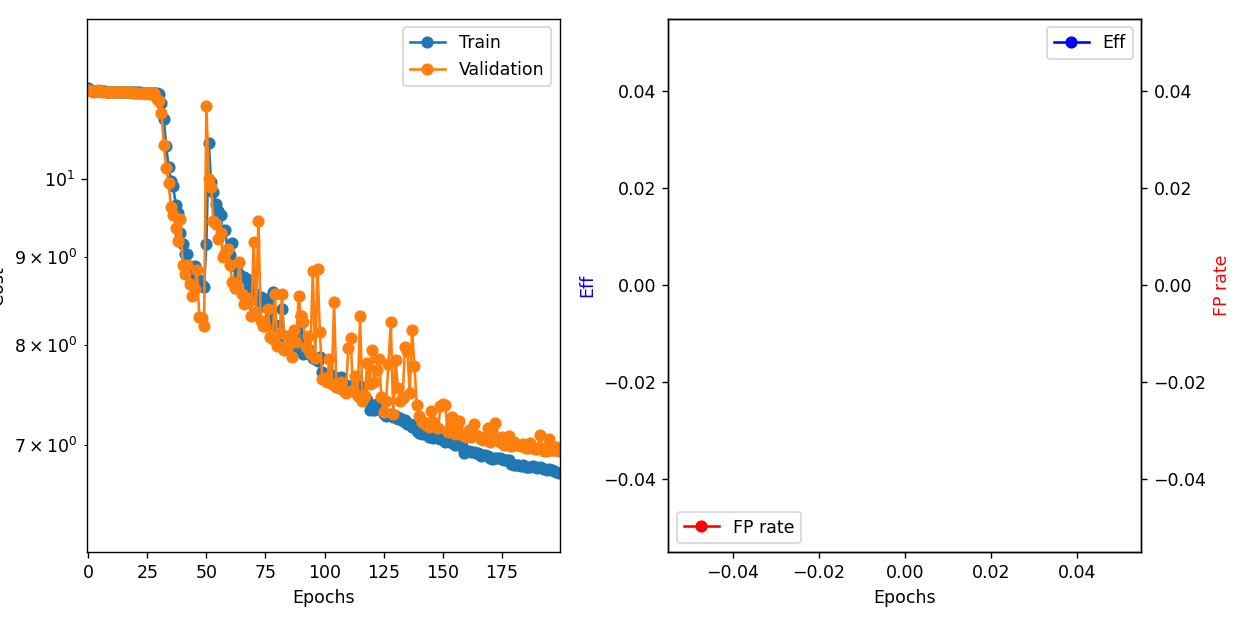

In [16]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [17]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True, step_schedule=step_schedule):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')
    #mine
    param_states.append(get_param_state(model))

Number of batches: train = 1125, val = 125


Number of batches: train = 1125, val = 125


lr inital: 0.0001
Epoch 0 | exponent is 0
lr factor is 0.7 ^ 0
final lr: 0.0001
Epoch 0: train=11.2849, val=11.2603, took 45.611 s


lr inital: 0.0001
Epoch 1 | exponent is 0
lr factor is 0.7 ^ 0
final lr: 0.0001
Epoch 1: train=11.2563, val=11.2478, took 42.657 s


lr inital: 0.0001
Epoch 2 | exponent is 0
lr factor is 0.7 ^ 0
final lr: 0.0001
Epoch 2: train=11.2495, val=11.2366, took 48.673 s


lr inital: 0.0001
Epoch 3 | exponent is 0
lr factor is 0.7 ^ 0
final lr: 0.0001
Epoch 3: train=11.2454, val=11.2417, took 42.794 s


lr inital: 0.0001
Epoch 4 | exponent is 0
lr factor is 0.7 ^ 0
final lr: 0.0001
Epoch 4: train=11.2419, val=11.2539, took 44.353 s


lr inital: 0.0001
Epoch 5 | exponent is 0
lr factor is 0.7 ^ 0
final lr: 0.0001
Epoch 5: train=11.2404, val=11.242, took 44.617 s


lr inital: 0.0001
Epoch 6 | exponent is 0
lr factor is 0.7 ^ 0
final lr: 0.0001
Epoch 6: train=11.239, val=11.2356, took 43.747 s


lr inital: 0.0001
Epoch 7 | exponent is 0
lr factor is 0.7 ^ 0
final lr: 0.0001
Epoch 7: train=11.2372, val=11.2345, took 48.611 s


lr inital: 0.0001
Epoch 8 | exponent is 0
lr factor is 0.7 ^ 0
final lr: 0.0001
Epoch 8: train=11.2359, val=11.2309, took 43.248 s


lr inital: 0.0001
Epoch 9 | exponent is 0
lr factor is 0.7 ^ 0
final lr: 0.0001
Epoch 9: train=11.2347, val=11.2321, took 46.016 s


lr inital: 0.0001
Epoch 10 | exponent is 0
lr factor is 0.7 ^ 0
final lr: 0.0001
Epoch 10: train=11.234, val=11.2327, took 45.657 s


lr inital: 0.0001
Epoch 11 | exponent is 0
lr factor is 0.7 ^ 0
final lr: 0.0001
Epoch 11: train=11.2323, val=11.2304, took 43.971 s


lr inital: 0.0001
Epoch 12 | exponent is 0
lr factor is 0.7 ^ 0
final lr: 0.0001
Epoch 12: train=11.2323, val=11.2263, took 49.441 s


lr inital: 0.0001
Epoch 13 | exponent is 0
lr factor is 0.7 ^ 0
final lr: 0.0001
Epoch 13: train=11.231, val=11.2264, took 43.984 s


lr inital: 0.0001
Epoch 14 | exponent is 0
lr factor is 0.7 ^ 0
final lr: 0.0001
Epoch 14: train=11.2306, val=11.226, took 47.333 s


lr inital: 0.0001
Epoch 15 | exponent is 0
lr factor is 0.7 ^ 0
final lr: 0.0001
Epoch 15: train=11.2298, val=11.2237, took 45.482 s


lr inital: 0.0001
Epoch 16 | exponent is 0
lr factor is 0.7 ^ 0
final lr: 0.0001
Epoch 16: train=11.2288, val=11.2229, took 44.649 s


lr inital: 0.0001
Epoch 17 | exponent is 0
lr factor is 0.7 ^ 0
final lr: 0.0001
Epoch 17: train=11.228, val=11.2222, took 49.102 s


lr inital: 0.0001
Epoch 18 | exponent is 1
lr factor is 0.7 ^ 1
final lr: 7e-05
Epoch 18: train=11.2279, val=11.2223, took 44.397 s


lr inital: 0.0001
Epoch 19 | exponent is 1
lr factor is 0.7 ^ 1
final lr: 7e-05
Epoch 19: train=11.2243, val=11.219, took 46.821 s


lr inital: 0.0001
Epoch 20 | exponent is 1
lr factor is 0.7 ^ 1
final lr: 7e-05
Epoch 20: train=11.2228, val=11.2192, took 43.888 s


lr inital: 0.0001
Epoch 21 | exponent is 1
lr factor is 0.7 ^ 1
final lr: 7e-05
Epoch 21: train=11.2226, val=11.2188, took 43.9 s


lr inital: 0.0001
Epoch 22 | exponent is 1
lr factor is 0.7 ^ 1
final lr: 7e-05
Epoch 22: train=11.2224, val=11.2196, took 48.876 s


lr inital: 0.0001
Epoch 23 | exponent is 1
lr factor is 0.7 ^ 1
final lr: 7e-05
Epoch 23: train=11.2217, val=11.218, took 44.701 s


lr inital: 0.0001
Epoch 24 | exponent is 1
lr factor is 0.7 ^ 1
final lr: 7e-05
Epoch 24: train=11.221, val=11.217, took 48.844 s


lr inital: 0.0001
Epoch 25 | exponent is 1
lr factor is 0.7 ^ 1
final lr: 7e-05
Epoch 25: train=11.22, val=11.2153, took 44.235 s


lr inital: 0.0001
Epoch 26 | exponent is 1
lr factor is 0.7 ^ 1
final lr: 7e-05
Epoch 26: train=11.2159, val=11.2029, took 44.288 s


lr inital: 0.0001
Epoch 27 | exponent is 1
lr factor is 0.7 ^ 1
final lr: 7e-05
Epoch 27: train=11.2149, val=11.2009, took 45.953 s


lr inital: 0.0001
Epoch 28 | exponent is 1
lr factor is 0.7 ^ 1
final lr: 7e-05
Epoch 28: train=11.2136, val=11.2154, took 44.738 s


lr inital: 0.0001
Epoch 29 | exponent is 1
lr factor is 0.7 ^ 1
final lr: 7e-05
Epoch 29: train=11.2089, val=11.1314, took 49.343 s


lr inital: 0.0001
Epoch 30 | exponent is 1
lr factor is 0.7 ^ 1
final lr: 7e-05
Epoch 30: train=11.1948, val=11.0976, took 44.409 s


lr inital: 0.0001
Epoch 31 | exponent is 1
lr factor is 0.7 ^ 1
final lr: 7e-05
Epoch 31: train=11.0673, val=10.9206, took 47.549 s


lr inital: 0.0001
Epoch 32 | exponent is 1
lr factor is 0.7 ^ 1
final lr: 7e-05
Epoch 32: train=10.8238, val=10.4626, took 45.787 s


lr inital: 0.0001
Epoch 33 | exponent is 1
lr factor is 0.7 ^ 1
final lr: 7e-05
Epoch 33: train=10.4395, val=10.1401, took 43.887 s


lr inital: 0.0001
Epoch 34 | exponent is 1
lr factor is 0.7 ^ 1
final lr: 7e-05
Epoch 34: train=10.162, val=9.94793, took 49.095 s


lr inital: 0.0001
Epoch 35 | exponent is 1
lr factor is 0.7 ^ 1
final lr: 7e-05
Epoch 35: train=9.97208, val=9.62225, took 43.594 s


lr inital: 0.0001
Epoch 36 | exponent is 1
lr factor is 0.7 ^ 1
final lr: 7e-05
Epoch 36: train=9.89793, val=9.52683, took 46.347 s


lr inital: 0.0001
Epoch 37 | exponent is 1
lr factor is 0.7 ^ 1
final lr: 7e-05
Epoch 37: train=9.65777, val=9.36079, took 43.753 s


lr inital: 0.0001
Epoch 38 | exponent is 2
lr factor is 0.7 ^ 2
final lr: 4.9e-05
Epoch 38: train=9.54825, val=9.19639, took 43.673 s


lr inital: 0.0001
Epoch 39 | exponent is 2
lr factor is 0.7 ^ 2
final lr: 4.9e-05
Epoch 39: train=9.299, val=9.47559, took 48.522 s


lr inital: 0.0001
Epoch 40 | exponent is 2
lr factor is 0.7 ^ 2
final lr: 4.9e-05
Epoch 40: train=9.16292, val=8.91206, took 44.177 s


lr inital: 0.0001
Epoch 41 | exponent is 2
lr factor is 0.7 ^ 2
final lr: 4.9e-05
Epoch 41: train=9.04319, val=8.80147, took 48.56 s


lr inital: 0.0001
Epoch 42 | exponent is 2
lr factor is 0.7 ^ 2
final lr: 4.9e-05
Epoch 42: train=9.04578, val=8.90441, took 45.567 s


lr inital: 0.0001
Epoch 43 | exponent is 2
lr factor is 0.7 ^ 2
final lr: 4.9e-05
Epoch 43: train=8.89491, val=8.68163, took 45.49 s


lr inital: 0.0001
Epoch 44 | exponent is 2
lr factor is 0.7 ^ 2
final lr: 4.9e-05
Epoch 44: train=8.82591, val=8.54441, took 46.733 s


lr inital: 0.0001
Epoch 45 | exponent is 2
lr factor is 0.7 ^ 2
final lr: 4.9e-05
Epoch 45: train=8.89833, val=8.62787, took 45.609 s


lr inital: 0.0001
Epoch 46 | exponent is 2
lr factor is 0.7 ^ 2
final lr: 4.9e-05
Epoch 46: train=8.73947, val=8.8538, took 49.473 s


lr inital: 0.0001
Epoch 47 | exponent is 2
lr factor is 0.7 ^ 2
final lr: 4.9e-05
Epoch 47: train=8.73592, val=8.31435, took 45.092 s


lr inital: 0.0001
Epoch 48 | exponent is 2
lr factor is 0.7 ^ 2
final lr: 4.9e-05
Epoch 48: train=8.66754, val=8.29823, took 47.499 s


lr inital: 0.0001
Epoch 49 | exponent is 2
lr factor is 0.7 ^ 2
final lr: 4.9e-05
Epoch 49: train=8.64551, val=8.20542, took 44.957 s


lr inital: 0.0001
Epoch 50 | exponent is 2
lr factor is 0.7 ^ 2
final lr: 4.9e-05
Epoch 50: train=9.16567, val=11.0272, took 45.134 s


lr inital: 0.0001
Epoch 51 | exponent is 2
lr factor is 0.7 ^ 2
final lr: 4.9e-05
Epoch 51: train=10.4929, val=9.99573, took 48.034 s


lr inital: 0.0001
Epoch 52 | exponent is 2
lr factor is 0.7 ^ 2
final lr: 4.9e-05
Epoch 52: train=9.9526, val=9.89371, took 44.54 s


lr inital: 0.0001
Epoch 53 | exponent is 2
lr factor is 0.7 ^ 2
final lr: 4.9e-05
Epoch 53: train=9.81612, val=9.44555, took 48.983 s


lr inital: 0.0001
Epoch 54 | exponent is 2
lr factor is 0.7 ^ 2
final lr: 4.9e-05
Epoch 54: train=9.66356, val=9.41413, took 44.554 s


lr inital: 0.0001
Epoch 55 | exponent is 2
lr factor is 0.7 ^ 2
final lr: 4.9e-05
Epoch 55: train=9.58129, val=9.22619, took 45.822 s


lr inital: 0.0001
Epoch 56 | exponent is 2
lr factor is 0.7 ^ 2
final lr: 4.9e-05
Epoch 56: train=9.52145, val=9.29177, took 46.943 s


lr inital: 0.0001
Epoch 57 | exponent is 2
lr factor is 0.7 ^ 2
final lr: 4.9e-05
Epoch 57: train=9.31907, val=8.99915, took 44.264 s


lr inital: 0.0001
Epoch 58 | exponent is 3
lr factor is 0.7 ^ 3
final lr: 3.4299999999999993e-05
Epoch 58: train=9.33787, val=9.05156, took 49.26 s


lr inital: 0.0001
Epoch 59 | exponent is 3
lr factor is 0.7 ^ 3
final lr: 3.4299999999999993e-05
Epoch 59: train=9.04768, val=9.10357, took 44.319 s


lr inital: 0.0001
Epoch 60 | exponent is 3
lr factor is 0.7 ^ 3
final lr: 3.4299999999999993e-05
Epoch 60: train=9.03008, val=8.90328, took 47.542 s


lr inital: 0.0001
Epoch 61 | exponent is 3
lr factor is 0.7 ^ 3
final lr: 3.4299999999999993e-05
Epoch 61: train=9.17517, val=8.70831, took 44.36 s


lr inital: 0.0001
Epoch 62 | exponent is 3
lr factor is 0.7 ^ 3
final lr: 3.4299999999999993e-05
Epoch 62: train=8.8915, val=8.64173, took 44.929 s


lr inital: 0.0001
Epoch 63 | exponent is 3
lr factor is 0.7 ^ 3
final lr: 3.4299999999999993e-05
Epoch 63: train=8.90766, val=8.6773, took 46.725 s


lr inital: 0.0001
Epoch 64 | exponent is 3
lr factor is 0.7 ^ 3
final lr: 3.4299999999999993e-05
Epoch 64: train=8.79792, val=8.94819, took 44.353 s


lr inital: 0.0001
Epoch 65 | exponent is 3
lr factor is 0.7 ^ 3
final lr: 3.4299999999999993e-05
Epoch 65: train=8.76108, val=8.56773, took 49.311 s


lr inital: 0.0001
Epoch 66 | exponent is 3
lr factor is 0.7 ^ 3
final lr: 3.4299999999999993e-05
Epoch 66: train=8.77068, val=8.45026, took 43.487 s


lr inital: 0.0001
Epoch 67 | exponent is 3
lr factor is 0.7 ^ 3
final lr: 3.4299999999999993e-05
Epoch 67: train=8.74148, val=8.52188, took 45.097 s


lr inital: 0.0001
Epoch 68 | exponent is 3
lr factor is 0.7 ^ 3
final lr: 3.4299999999999993e-05
Epoch 68: train=8.66134, val=8.48689, took 45.965 s


lr inital: 0.0001
Epoch 69 | exponent is 3
lr factor is 0.7 ^ 3
final lr: 3.4299999999999993e-05
Epoch 69: train=8.64361, val=8.32272, took 44.483 s


lr inital: 0.0001
Epoch 70 | exponent is 3
lr factor is 0.7 ^ 3
final lr: 3.4299999999999993e-05
Epoch 70: train=8.58288, val=9.18188, took 49.073 s


lr inital: 0.0001
Epoch 71 | exponent is 3
lr factor is 0.7 ^ 3
final lr: 3.4299999999999993e-05
Epoch 71: train=8.50932, val=8.36966, took 43.827 s


lr inital: 0.0001
Epoch 72 | exponent is 3
lr factor is 0.7 ^ 3
final lr: 3.4299999999999993e-05
Epoch 72: train=8.50255, val=9.44677, took 47.677 s


lr inital: 0.0001
Epoch 73 | exponent is 3
lr factor is 0.7 ^ 3
final lr: 3.4299999999999993e-05
Epoch 73: train=8.52923, val=8.26634, took 45.456 s


lr inital: 0.0001
Epoch 74 | exponent is 3
lr factor is 0.7 ^ 3
final lr: 3.4299999999999993e-05
Epoch 74: train=8.43654, val=8.20709, took 45.526 s


lr inital: 0.0001
Epoch 75 | exponent is 3
lr factor is 0.7 ^ 3
final lr: 3.4299999999999993e-05
Epoch 75: train=8.44362, val=8.20694, took 49.778 s


lr inital: 0.0001
Epoch 76 | exponent is 3
lr factor is 0.7 ^ 3
final lr: 3.4299999999999993e-05
Epoch 76: train=8.50685, val=8.39472, took 44.663 s


lr inital: 0.0001
Epoch 77 | exponent is 3
lr factor is 0.7 ^ 3
final lr: 3.4299999999999993e-05
Epoch 77: train=8.31108, val=8.09425, took 47.363 s


lr inital: 0.0001
Epoch 78 | exponent is 4
lr factor is 0.7 ^ 4
final lr: 2.4009999999999995e-05
Epoch 78: train=8.59186, val=8.07123, took 45.01 s


lr inital: 0.0001
Epoch 79 | exponent is 4
lr factor is 0.7 ^ 4
final lr: 2.4009999999999995e-05
Epoch 79: train=8.22544, val=8.56578, took 45.417 s


lr inital: 0.0001
Epoch 80 | exponent is 4
lr factor is 0.7 ^ 4
final lr: 2.4009999999999995e-05
Epoch 80: train=8.21372, val=7.99592, took 49.167 s


lr inital: 0.0001
Epoch 81 | exponent is 4
lr factor is 0.7 ^ 4
final lr: 2.4009999999999995e-05
Epoch 81: train=8.12646, val=8.13445, took 45.362 s


lr inital: 0.0001
Epoch 82 | exponent is 4
lr factor is 0.7 ^ 4
final lr: 2.4009999999999995e-05
Epoch 82: train=8.39451, val=8.57397, took 50.012 s


lr inital: 0.0001
Epoch 83 | exponent is 4
lr factor is 0.7 ^ 4
final lr: 2.4009999999999995e-05
Epoch 83: train=8.09866, val=7.94742, took 44.637 s


lr inital: 0.0001
Epoch 84 | exponent is 4
lr factor is 0.7 ^ 4
final lr: 2.4009999999999995e-05
Epoch 84: train=8.06774, val=8.10362, took 44.865 s


lr inital: 0.0001
Epoch 85 | exponent is 4
lr factor is 0.7 ^ 4
final lr: 2.4009999999999995e-05
Epoch 85: train=8.08437, val=8.02306, took 46.136 s


lr inital: 0.0001
Epoch 86 | exponent is 4
lr factor is 0.7 ^ 4
final lr: 2.4009999999999995e-05
Epoch 86: train=8.05376, val=7.87432, took 43.919 s


lr inital: 0.0001
Epoch 87 | exponent is 4
lr factor is 0.7 ^ 4
final lr: 2.4009999999999995e-05
Epoch 87: train=8.01186, val=8.16967, took 49.411 s


lr inital: 0.0001
Epoch 88 | exponent is 4
lr factor is 0.7 ^ 4
final lr: 2.4009999999999995e-05
Epoch 88: train=7.97448, val=8.03746, took 44.27 s


lr inital: 0.0001
Epoch 89 | exponent is 4
lr factor is 0.7 ^ 4
final lr: 2.4009999999999995e-05
Epoch 89: train=8.03481, val=8.54227, took 45.553 s


lr inital: 0.0001
Epoch 90 | exponent is 4
lr factor is 0.7 ^ 4
final lr: 2.4009999999999995e-05
Epoch 90: train=8.324, val=8.32548, took 46.324 s


lr inital: 0.0001
Epoch 91 | exponent is 4
lr factor is 0.7 ^ 4
final lr: 2.4009999999999995e-05
Epoch 91: train=7.90413, val=8.25793, took 43.791 s


lr inital: 0.0001
Epoch 92 | exponent is 4
lr factor is 0.7 ^ 4
final lr: 2.4009999999999995e-05
Epoch 92: train=7.9636, val=7.98217, took 49.598 s


lr inital: 0.0001
Epoch 93 | exponent is 4
lr factor is 0.7 ^ 4
final lr: 2.4009999999999995e-05
Epoch 93: train=7.95884, val=8.10439, took 44.784 s


lr inital: 0.0001
Epoch 94 | exponent is 4
lr factor is 0.7 ^ 4
final lr: 2.4009999999999995e-05
Epoch 94: train=7.90549, val=7.92289, took 48.104 s


lr inital: 0.0001
Epoch 95 | exponent is 4
lr factor is 0.7 ^ 4
final lr: 2.4009999999999995e-05
Epoch 95: train=7.87055, val=8.84049, took 46.745 s


lr inital: 0.0001
Epoch 96 | exponent is 4
lr factor is 0.7 ^ 4
final lr: 2.4009999999999995e-05
Epoch 96: train=7.85614, val=7.86588, took 43.984 s


lr inital: 0.0001
Epoch 97 | exponent is 4
lr factor is 0.7 ^ 4
final lr: 2.4009999999999995e-05
Epoch 97: train=7.83424, val=8.85518, took 49.085 s


lr inital: 0.0001
Epoch 98 | exponent is 5
lr factor is 0.7 ^ 5
final lr: 1.6806999999999993e-05
Epoch 98: train=7.87407, val=8.14282, took 44.984 s


lr inital: 0.0001
Epoch 99 | exponent is 5
lr factor is 0.7 ^ 5
final lr: 1.6806999999999993e-05
Epoch 99: train=7.71437, val=7.65044, took 47.466 s


lr inital: 0.0001
Epoch 100 | exponent is 5
lr factor is 0.7 ^ 5
final lr: 1.6806999999999993e-05
Epoch 100: train=7.69611, val=7.66104, took 44.093 s


lr inital: 0.0001
Epoch 101 | exponent is 5
lr factor is 0.7 ^ 5
final lr: 1.6806999999999993e-05
Epoch 101: train=7.69546, val=7.61963, took 44.748 s


lr inital: 0.0001
Epoch 102 | exponent is 5
lr factor is 0.7 ^ 5
final lr: 1.6806999999999993e-05
Epoch 102: train=7.66588, val=7.85157, took 49.51 s


lr inital: 0.0001
Epoch 103 | exponent is 5
lr factor is 0.7 ^ 5
final lr: 1.6806999999999993e-05
Epoch 103: train=7.68653, val=7.59634, took 44.241 s


lr inital: 0.0001
Epoch 104 | exponent is 5
lr factor is 0.7 ^ 5
final lr: 1.6806999999999993e-05
Epoch 104: train=7.65908, val=8.4746, took 47.844 s


lr inital: 0.0001
Epoch 105 | exponent is 5
lr factor is 0.7 ^ 5
final lr: 1.6806999999999993e-05
Epoch 105: train=7.62108, val=7.56679, took 44.651 s


lr inital: 0.0001
Epoch 106 | exponent is 5
lr factor is 0.7 ^ 5
final lr: 1.6806999999999993e-05
Epoch 106: train=7.59523, val=7.5551, took 44.759 s


lr inital: 0.0001
Epoch 107 | exponent is 5
lr factor is 0.7 ^ 5
final lr: 1.6806999999999993e-05
Epoch 107: train=7.67004, val=7.62035, took 45.966 s


lr inital: 0.0001
Epoch 108 | exponent is 5
lr factor is 0.7 ^ 5
final lr: 1.6806999999999993e-05
Epoch 108: train=7.60138, val=7.53054, took 43.871 s


lr inital: 0.0001
Epoch 109 | exponent is 5
lr factor is 0.7 ^ 5
final lr: 1.6806999999999993e-05
Epoch 109: train=7.5852, val=7.50174, took 48.866 s


lr inital: 0.0001
Epoch 110 | exponent is 5
lr factor is 0.7 ^ 5
final lr: 1.6806999999999993e-05
Epoch 110: train=7.57993, val=7.9683, took 43.974 s


lr inital: 0.0001
Epoch 111 | exponent is 5
lr factor is 0.7 ^ 5
final lr: 1.6806999999999993e-05
Epoch 111: train=7.55226, val=8.08379, took 43.967 s


lr inital: 0.0001
Epoch 112 | exponent is 5
lr factor is 0.7 ^ 5
final lr: 1.6806999999999993e-05
Epoch 112: train=7.5303, val=7.53209, took 45.634 s


lr inital: 0.0001
Epoch 113 | exponent is 5
lr factor is 0.7 ^ 5
final lr: 1.6806999999999993e-05
Epoch 113: train=7.59937, val=7.67628, took 43.619 s


lr inital: 0.0001
Epoch 114 | exponent is 5
lr factor is 0.7 ^ 5
final lr: 1.6806999999999993e-05
Epoch 114: train=7.52416, val=7.47548, took 48.742 s


lr inital: 0.0001
Epoch 115 | exponent is 5
lr factor is 0.7 ^ 5
final lr: 1.6806999999999993e-05
Epoch 115: train=7.57531, val=8.31898, took 43.607 s


lr inital: 0.0001
Epoch 116 | exponent is 5
lr factor is 0.7 ^ 5
final lr: 1.6806999999999993e-05
Epoch 116: train=7.50728, val=7.4238, took 43.69 s


lr inital: 0.0001
Epoch 117 | exponent is 5
lr factor is 0.7 ^ 5
final lr: 1.6806999999999993e-05
Epoch 117: train=7.45434, val=7.47406, took 46.017 s


lr inital: 0.0001
Epoch 118 | exponent is 6
lr factor is 0.7 ^ 6
final lr: 1.1764899999999996e-05
Epoch 118: train=7.43396, val=7.81231, took 43.95 s


lr inital: 0.0001
Epoch 119 | exponent is 6
lr factor is 0.7 ^ 6
final lr: 1.1764899999999996e-05
Epoch 119: train=7.3318, val=7.5937, took 49.314 s


lr inital: 0.0001
Epoch 120 | exponent is 6
lr factor is 0.7 ^ 6
final lr: 1.1764899999999996e-05
Epoch 120: train=7.37033, val=7.95071, took 44.875 s


lr inital: 0.0001
Epoch 121 | exponent is 6
lr factor is 0.7 ^ 6
final lr: 1.1764899999999996e-05
Epoch 121: train=7.33481, val=7.61716, took 45.932 s


lr inital: 0.0001
Epoch 122 | exponent is 6
lr factor is 0.7 ^ 6
final lr: 1.1764899999999996e-05
Epoch 122: train=7.39594, val=7.7421, took 46.447 s


lr inital: 0.0001
Epoch 123 | exponent is 6
lr factor is 0.7 ^ 6
final lr: 1.1764899999999996e-05
Epoch 123: train=7.34314, val=7.8566, took 44.503 s


lr inital: 0.0001
Epoch 124 | exponent is 6
lr factor is 0.7 ^ 6
final lr: 1.1764899999999996e-05
Epoch 124: train=7.36317, val=7.46479, took 49.308 s


lr inital: 0.0001
Epoch 125 | exponent is 6
lr factor is 0.7 ^ 6
final lr: 1.1764899999999996e-05
Epoch 125: train=7.29356, val=7.31665, took 44.793 s


lr inital: 0.0001
Epoch 126 | exponent is 6
lr factor is 0.7 ^ 6
final lr: 1.1764899999999996e-05
Epoch 126: train=7.27746, val=7.42126, took 45.254 s


lr inital: 0.0001
Epoch 127 | exponent is 6
lr factor is 0.7 ^ 6
final lr: 1.1764899999999996e-05
Epoch 127: train=7.29152, val=7.80079, took 46.869 s


lr inital: 0.0001
Epoch 128 | exponent is 6
lr factor is 0.7 ^ 6
final lr: 1.1764899999999996e-05
Epoch 128: train=7.29538, val=8.25367, took 44.535 s


lr inital: 0.0001
Epoch 129 | exponent is 6
lr factor is 0.7 ^ 6
final lr: 1.1764899999999996e-05
Epoch 129: train=7.26927, val=7.29808, took 49.61 s


lr inital: 0.0001
Epoch 130 | exponent is 6
lr factor is 0.7 ^ 6
final lr: 1.1764899999999996e-05
Epoch 130: train=7.27816, val=7.84793, took 44.409 s


lr inital: 0.0001
Epoch 131 | exponent is 6
lr factor is 0.7 ^ 6
final lr: 1.1764899999999996e-05
Epoch 131: train=7.24631, val=7.5534, took 46.298 s


lr inital: 0.0001
Epoch 132 | exponent is 6
lr factor is 0.7 ^ 6
final lr: 1.1764899999999996e-05
Epoch 132: train=7.26043, val=7.42132, took 47.232 s


lr inital: 0.0001
Epoch 133 | exponent is 6
lr factor is 0.7 ^ 6
final lr: 1.1764899999999996e-05
Epoch 133: train=7.23065, val=7.45269, took 44.553 s


lr inital: 0.0001
Epoch 134 | exponent is 6
lr factor is 0.7 ^ 6
final lr: 1.1764899999999996e-05
Epoch 134: train=7.23606, val=7.98624, took 49.713 s


lr inital: 0.0001
Epoch 135 | exponent is 6
lr factor is 0.7 ^ 6
final lr: 1.1764899999999996e-05
Epoch 135: train=7.20062, val=7.93623, took 45.252 s


lr inital: 0.0001
Epoch 136 | exponent is 6
lr factor is 0.7 ^ 6
final lr: 1.1764899999999996e-05
Epoch 136: train=7.20299, val=7.50391, took 46.311 s


lr inital: 0.0001
Epoch 137 | exponent is 6
lr factor is 0.7 ^ 6
final lr: 1.1764899999999996e-05
Epoch 137: train=7.17104, val=8.17081, took 46.984 s


lr inital: 0.0001
Epoch 138 | exponent is 7
lr factor is 0.7 ^ 7
final lr: 8.235429999999996e-06
Epoch 138: train=7.18799, val=7.77823, took 44.295 s


lr inital: 0.0001
Epoch 139 | exponent is 7
lr factor is 0.7 ^ 7
final lr: 8.235429999999996e-06
Epoch 139: train=7.13155, val=7.38588, took 49.083 s


lr inital: 0.0001
Epoch 140 | exponent is 7
lr factor is 0.7 ^ 7
final lr: 8.235429999999996e-06
Epoch 140: train=7.11395, val=7.28074, took 44.725 s


lr inital: 0.0001
Epoch 141 | exponent is 7
lr factor is 0.7 ^ 7
final lr: 8.235429999999996e-06
Epoch 141: train=7.10531, val=7.21809, took 45.138 s


lr inital: 0.0001
Epoch 142 | exponent is 7
lr factor is 0.7 ^ 7
final lr: 8.235429999999996e-06
Epoch 142: train=7.11478, val=7.21859, took 45.38 s


lr inital: 0.0001
Epoch 143 | exponent is 7
lr factor is 0.7 ^ 7
final lr: 8.235429999999996e-06
Epoch 143: train=7.10384, val=7.193, took 44.298 s


lr inital: 0.0001
Epoch 144 | exponent is 7
lr factor is 0.7 ^ 7
final lr: 8.235429999999996e-06
Epoch 144: train=7.07392, val=7.16944, took 48.718 s


lr inital: 0.0001
Epoch 145 | exponent is 7
lr factor is 0.7 ^ 7
final lr: 8.235429999999996e-06
Epoch 145: train=7.07523, val=7.32898, took 45.033 s


lr inital: 0.0001
Epoch 146 | exponent is 7
lr factor is 0.7 ^ 7
final lr: 8.235429999999996e-06
Epoch 146: train=7.07095, val=7.22152, took 46.732 s


lr inital: 0.0001
Epoch 147 | exponent is 7
lr factor is 0.7 ^ 7
final lr: 8.235429999999996e-06
Epoch 147: train=7.07163, val=7.17569, took 46.228 s


lr inital: 0.0001
Epoch 148 | exponent is 7
lr factor is 0.7 ^ 7
final lr: 8.235429999999996e-06
Epoch 148: train=7.07033, val=7.15896, took 44.575 s


lr inital: 0.0001
Epoch 149 | exponent is 7
lr factor is 0.7 ^ 7
final lr: 8.235429999999996e-06
Epoch 149: train=7.05626, val=7.37818, took 49.372 s


lr inital: 0.0001
Epoch 150 | exponent is 7
lr factor is 0.7 ^ 7
final lr: 8.235429999999996e-06
Epoch 150: train=7.05293, val=7.39973, took 45.054 s


lr inital: 0.0001
Epoch 151 | exponent is 7
lr factor is 0.7 ^ 7
final lr: 8.235429999999996e-06
Epoch 151: train=7.02658, val=7.38404, took 47.248 s


lr inital: 0.0001
Epoch 152 | exponent is 7
lr factor is 0.7 ^ 7
final lr: 8.235429999999996e-06
Epoch 152: train=7.03566, val=7.1284, took 45.433 s


lr inital: 0.0001
Epoch 153 | exponent is 7
lr factor is 0.7 ^ 7
final lr: 8.235429999999996e-06
Epoch 153: train=7.02639, val=7.17551, took 44.584 s


lr inital: 0.0001
Epoch 154 | exponent is 7
lr factor is 0.7 ^ 7
final lr: 8.235429999999996e-06
Epoch 154: train=7.02178, val=7.26456, took 49.181 s


lr inital: 0.0001
Epoch 155 | exponent is 7
lr factor is 0.7 ^ 7
final lr: 8.235429999999996e-06
Epoch 155: train=7.00187, val=7.10427, took 44.869 s


lr inital: 0.0001
Epoch 156 | exponent is 7
lr factor is 0.7 ^ 7
final lr: 8.235429999999996e-06
Epoch 156: train=7.01941, val=7.16914, took 47.275 s


lr inital: 0.0001
Epoch 157 | exponent is 7
lr factor is 0.7 ^ 7
final lr: 8.235429999999996e-06
Epoch 157: train=6.99952, val=7.23274, took 45.643 s


lr inital: 0.0001
Epoch 158 | exponent is 8
lr factor is 0.7 ^ 8
final lr: 5.764800999999997e-06
Epoch 158: train=6.98836, val=7.09875, took 44.526 s


lr inital: 0.0001
Epoch 159 | exponent is 8
lr factor is 0.7 ^ 8
final lr: 5.764800999999997e-06
Epoch 159: train=6.92551, val=7.0918, took 49.295 s


lr inital: 0.0001
Epoch 160 | exponent is 8
lr factor is 0.7 ^ 8
final lr: 5.764800999999997e-06
Epoch 160: train=6.94012, val=7.07218, took 45.087 s


lr inital: 0.0001
Epoch 161 | exponent is 8
lr factor is 0.7 ^ 8
final lr: 5.764800999999997e-06
Epoch 161: train=6.94122, val=7.14331, took 48.481 s


lr inital: 0.0001
Epoch 162 | exponent is 8
lr factor is 0.7 ^ 8
final lr: 5.764800999999997e-06
Epoch 162: train=6.93399, val=7.07316, took 45.744 s


lr inital: 0.0001
Epoch 163 | exponent is 8
lr factor is 0.7 ^ 8
final lr: 5.764800999999997e-06
Epoch 163: train=6.93399, val=7.20155, took 44.485 s


lr inital: 0.0001
Epoch 164 | exponent is 8
lr factor is 0.7 ^ 8
final lr: 5.764800999999997e-06
Epoch 164: train=6.92348, val=7.0906, took 48.211 s


lr inital: 0.0001
Epoch 165 | exponent is 8
lr factor is 0.7 ^ 8
final lr: 5.764800999999997e-06
Epoch 165: train=6.92291, val=7.08227, took 44.799 s


lr inital: 0.0001
Epoch 166 | exponent is 8
lr factor is 0.7 ^ 8
final lr: 5.764800999999997e-06
Epoch 166: train=6.90029, val=7.05987, took 48.468 s


lr inital: 0.0001
Epoch 167 | exponent is 8
lr factor is 0.7 ^ 8
final lr: 5.764800999999997e-06
Epoch 167: train=6.90754, val=7.04437, took 44.913 s


lr inital: 0.0001
Epoch 168 | exponent is 8
lr factor is 0.7 ^ 8
final lr: 5.764800999999997e-06
Epoch 168: train=6.90512, val=7.07775, took 44.498 s


lr inital: 0.0001
Epoch 169 | exponent is 8
lr factor is 0.7 ^ 8
final lr: 5.764800999999997e-06
Epoch 169: train=6.90147, val=7.1584, took 48.155 s


lr inital: 0.0001
Epoch 170 | exponent is 8
lr factor is 0.7 ^ 8
final lr: 5.764800999999997e-06
Epoch 170: train=6.88381, val=7.03361, took 44.726 s


lr inital: 0.0001
Epoch 171 | exponent is 8
lr factor is 0.7 ^ 8
final lr: 5.764800999999997e-06
Epoch 171: train=6.87483, val=7.1354, took 49.506 s


lr inital: 0.0001
Epoch 172 | exponent is 8
lr factor is 0.7 ^ 8
final lr: 5.764800999999997e-06
Epoch 172: train=6.87556, val=7.20781, took 45.24 s


lr inital: 0.0001
Epoch 173 | exponent is 8
lr factor is 0.7 ^ 8
final lr: 5.764800999999997e-06
Epoch 173: train=6.87916, val=7.05946, took 45.394 s


lr inital: 0.0001
Epoch 174 | exponent is 8
lr factor is 0.7 ^ 8
final lr: 5.764800999999997e-06
Epoch 174: train=6.87616, val=7.03224, took 46.016 s


lr inital: 0.0001
Epoch 175 | exponent is 8
lr factor is 0.7 ^ 8
final lr: 5.764800999999997e-06
Epoch 175: train=6.87215, val=7.0719, took 45.433 s


lr inital: 0.0001
Epoch 176 | exponent is 8
lr factor is 0.7 ^ 8
final lr: 5.764800999999997e-06
Epoch 176: train=6.85845, val=7.00218, took 50.117 s


lr inital: 0.0001
Epoch 177 | exponent is 8
lr factor is 0.7 ^ 8
final lr: 5.764800999999997e-06
Epoch 177: train=6.85979, val=7.00869, took 48.29 s


lr inital: 0.0001
Epoch 178 | exponent is 9
lr factor is 0.7 ^ 9
final lr: 4.035360699999998e-06
Epoch 178: train=6.86397, val=7.08902, took 48.339 s


lr inital: 0.0001
Epoch 179 | exponent is 9
lr factor is 0.7 ^ 9
final lr: 4.035360699999998e-06
Epoch 179: train=6.82532, val=6.99393, took 49.713 s


lr inital: 0.0001
Epoch 180 | exponent is 9
lr factor is 0.7 ^ 9
final lr: 4.035360699999998e-06
Epoch 180: train=6.81747, val=7.0251, took 46.511 s


lr inital: 0.0001
Epoch 181 | exponent is 9
lr factor is 0.7 ^ 9
final lr: 4.035360699999998e-06
Epoch 181: train=6.81492, val=7.00509, took 49.263 s


lr inital: 0.0001
Epoch 182 | exponent is 9
lr factor is 0.7 ^ 9
final lr: 4.035360699999998e-06
Epoch 182: train=6.81484, val=7.00168, took 44.758 s


lr inital: 0.0001
Epoch 183 | exponent is 9
lr factor is 0.7 ^ 9
final lr: 4.035360699999998e-06
Epoch 183: train=6.81032, val=6.99139, took 48.429 s


lr inital: 0.0001
Epoch 184 | exponent is 9
lr factor is 0.7 ^ 9
final lr: 4.035360699999998e-06
Epoch 184: train=6.8165, val=7.00879, took 44.141 s


lr inital: 0.0001
Epoch 185 | exponent is 9
lr factor is 0.7 ^ 9
final lr: 4.035360699999998e-06
Epoch 185: train=6.80076, val=6.96871, took 42.859 s


lr inital: 0.0001
Epoch 186 | exponent is 9
lr factor is 0.7 ^ 9
final lr: 4.035360699999998e-06
Epoch 186: train=6.79983, val=6.97443, took 47.344 s


lr inital: 0.0001
Epoch 187 | exponent is 9
lr factor is 0.7 ^ 9
final lr: 4.035360699999998e-06
Epoch 187: train=6.79771, val=7.02108, took 42.828 s


lr inital: 0.0001
Epoch 188 | exponent is 9
lr factor is 0.7 ^ 9
final lr: 4.035360699999998e-06
Epoch 188: train=6.80542, val=6.97355, took 47.159 s


lr inital: 0.0001
Epoch 189 | exponent is 9
lr factor is 0.7 ^ 9
final lr: 4.035360699999998e-06
Epoch 189: train=6.79453, val=6.96583, took 43.396 s


lr inital: 0.0001
Epoch 190 | exponent is 9
lr factor is 0.7 ^ 9
final lr: 4.035360699999998e-06
Epoch 190: train=6.78953, val=6.96423, took 43.372 s


lr inital: 0.0001
Epoch 191 | exponent is 9
lr factor is 0.7 ^ 9
final lr: 4.035360699999998e-06
Epoch 191: train=6.79756, val=7.09896, took 48.774 s


lr inital: 0.0001
Epoch 192 | exponent is 9
lr factor is 0.7 ^ 9
final lr: 4.035360699999998e-06
Epoch 192: train=6.78421, val=6.9682, took 44.271 s


lr inital: 0.0001
Epoch 193 | exponent is 9
lr factor is 0.7 ^ 9
final lr: 4.035360699999998e-06
Epoch 193: train=6.78006, val=6.94804, took 46.825 s


lr inital: 0.0001
Epoch 194 | exponent is 9
lr factor is 0.7 ^ 9
final lr: 4.035360699999998e-06
Epoch 194: train=6.77147, val=6.94738, took 43.72 s


lr inital: 0.0001
Epoch 195 | exponent is 9
lr factor is 0.7 ^ 9
final lr: 4.035360699999998e-06
Epoch 195: train=6.77977, val=7.05637, took 44.649 s


lr inital: 0.0001
Epoch 196 | exponent is 9
lr factor is 0.7 ^ 9
final lr: 4.035360699999998e-06
Epoch 196: train=6.77011, val=6.95566, took 45.924 s


lr inital: 0.0001
Epoch 197 | exponent is 9
lr factor is 0.7 ^ 9
final lr: 4.035360699999998e-06
Epoch 197: train=6.76559, val=6.94995, took 43.998 s


lr inital: 0.0001
Epoch 198 | exponent is 10
lr factor is 0.7 ^ 10
final lr: 2.8247524899999986e-06
Epoch 198: train=6.75636, val=6.98057, took 48.946 s


lr inital: 0.0001
Epoch 199 | exponent is 10
lr factor is 0.7 ^ 10
final lr: 2.8247524899999986e-06
Epoch 199: train=6.73922, val=6.9474, took 43.881 s



Go ahead and save the final model (even though it was also saved above):

In [18]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [19]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

<IPython.core.display.Javascript object>


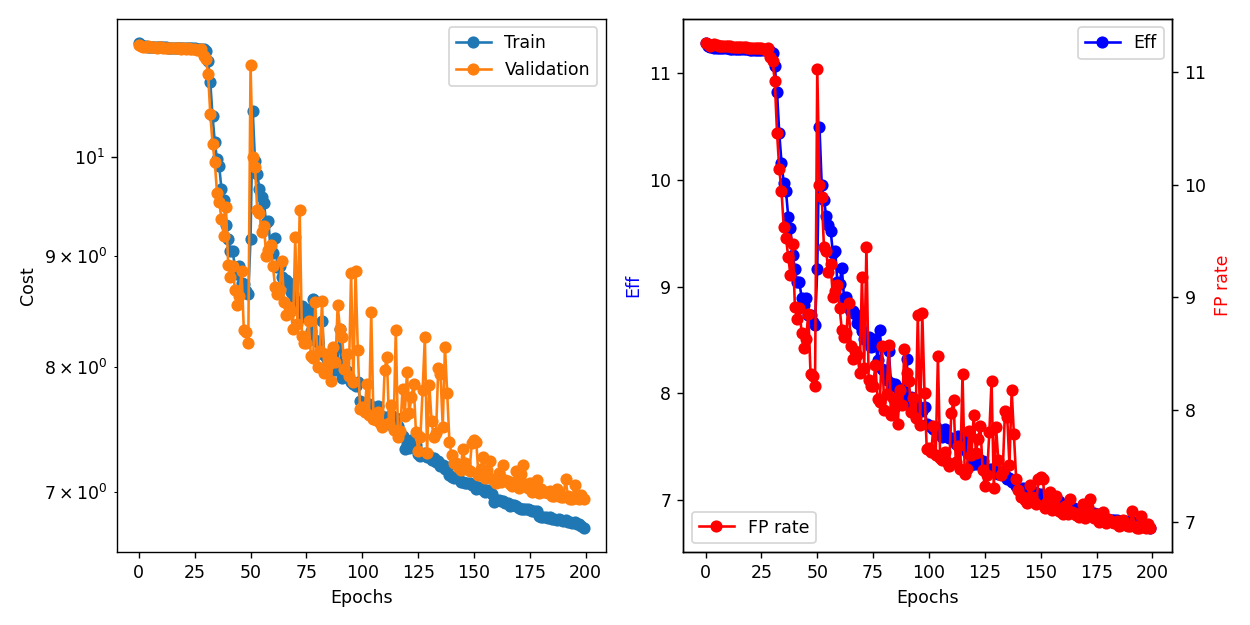

In [20]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [21]:
from functions.utils import state_dict_to_vector
def angle_between(a, b):
    return np.arccos(np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)))

angle_grids = []
grid_size = 25
num_epochs = n_epochs
num_epochs2 = 0

ep_intervals = [(np.arange(0, num_epochs+num_epochs2+1, grid_size)[i], np.arange(0, num_epochs+num_epochs2+1, grid_size)[i+1]) for i in range(len(np.arange(0, num_epochs+num_epochs2+1, grid_size))-1)]

for interval in ep_intervals:
    
    these_param_states = []
    for i in range(interval[0], interval[1]):
        if i % 100 == 0:
            print(i)
        these_param_states.append(param_states[i])
        #print("Loaded", file_names[i])
        
    interval_size = len(these_param_states)-1    
    these_steps = [these_param_states[i+1]-these_param_states[i] for i in range(interval_size)]
    
    this_angle_grid = np.zeros((interval_size, interval_size))
    
    for i in range(interval_size):
        for j in range(i+1, interval_size):#range(i+1, interval_size):
            angle = angle_between(these_steps[i], these_steps[j])
            this_angle_grid[i,j] = angle
            this_angle_grid[j,i] = angle
            
    angle_grids.append(this_angle_grid)

0
100


<IPython.core.display.Javascript object>


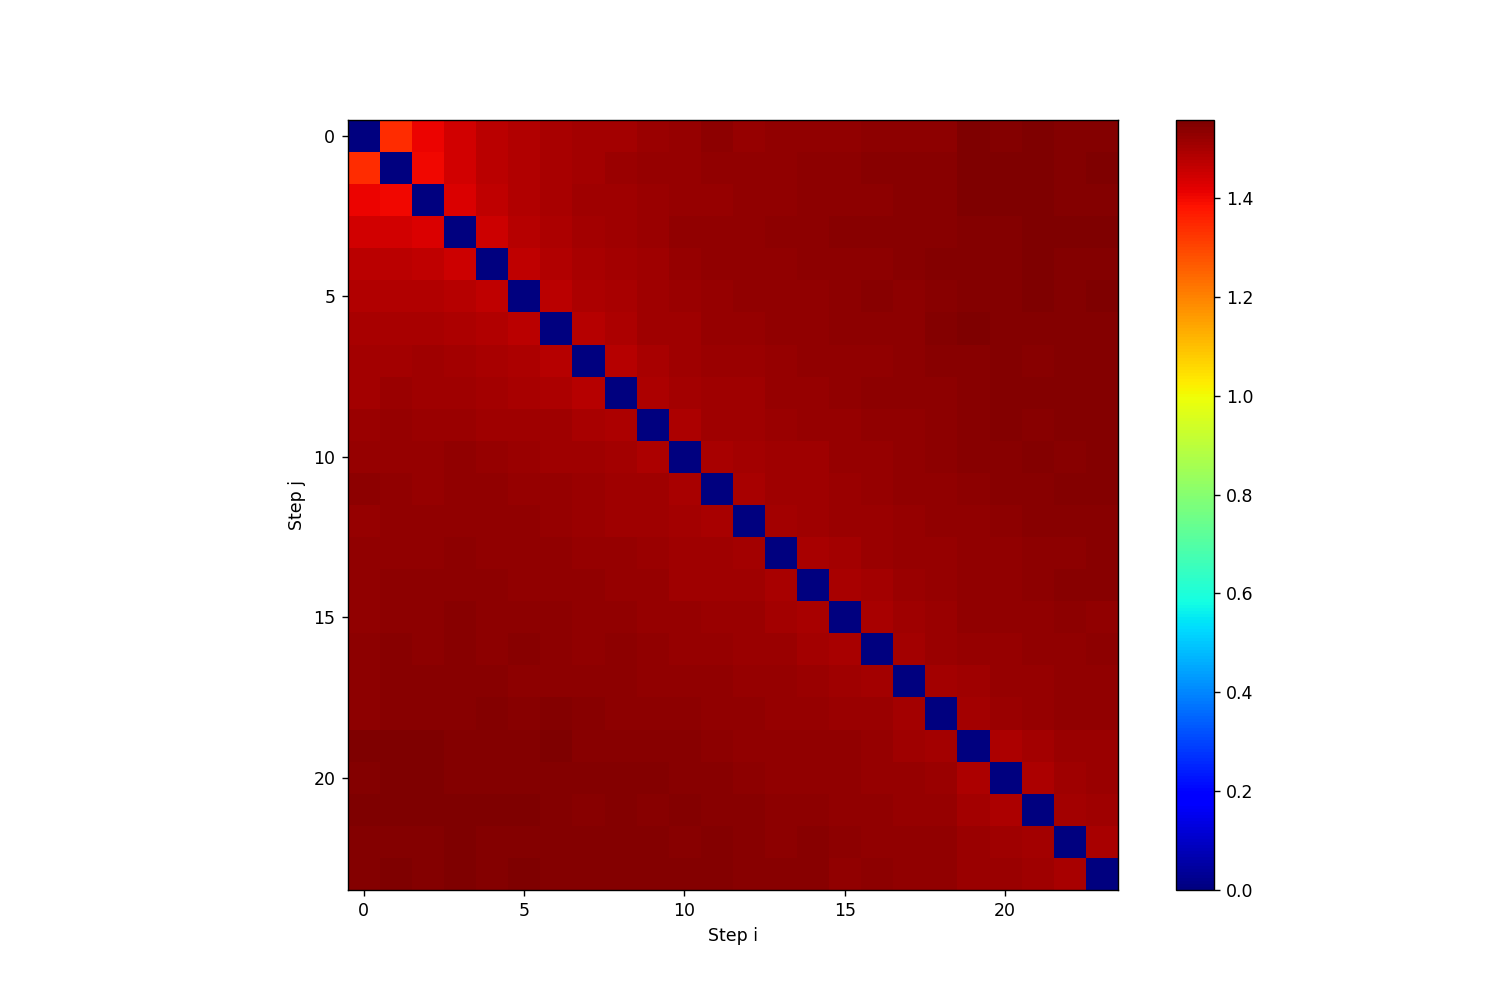

<IPython.core.display.Javascript object>


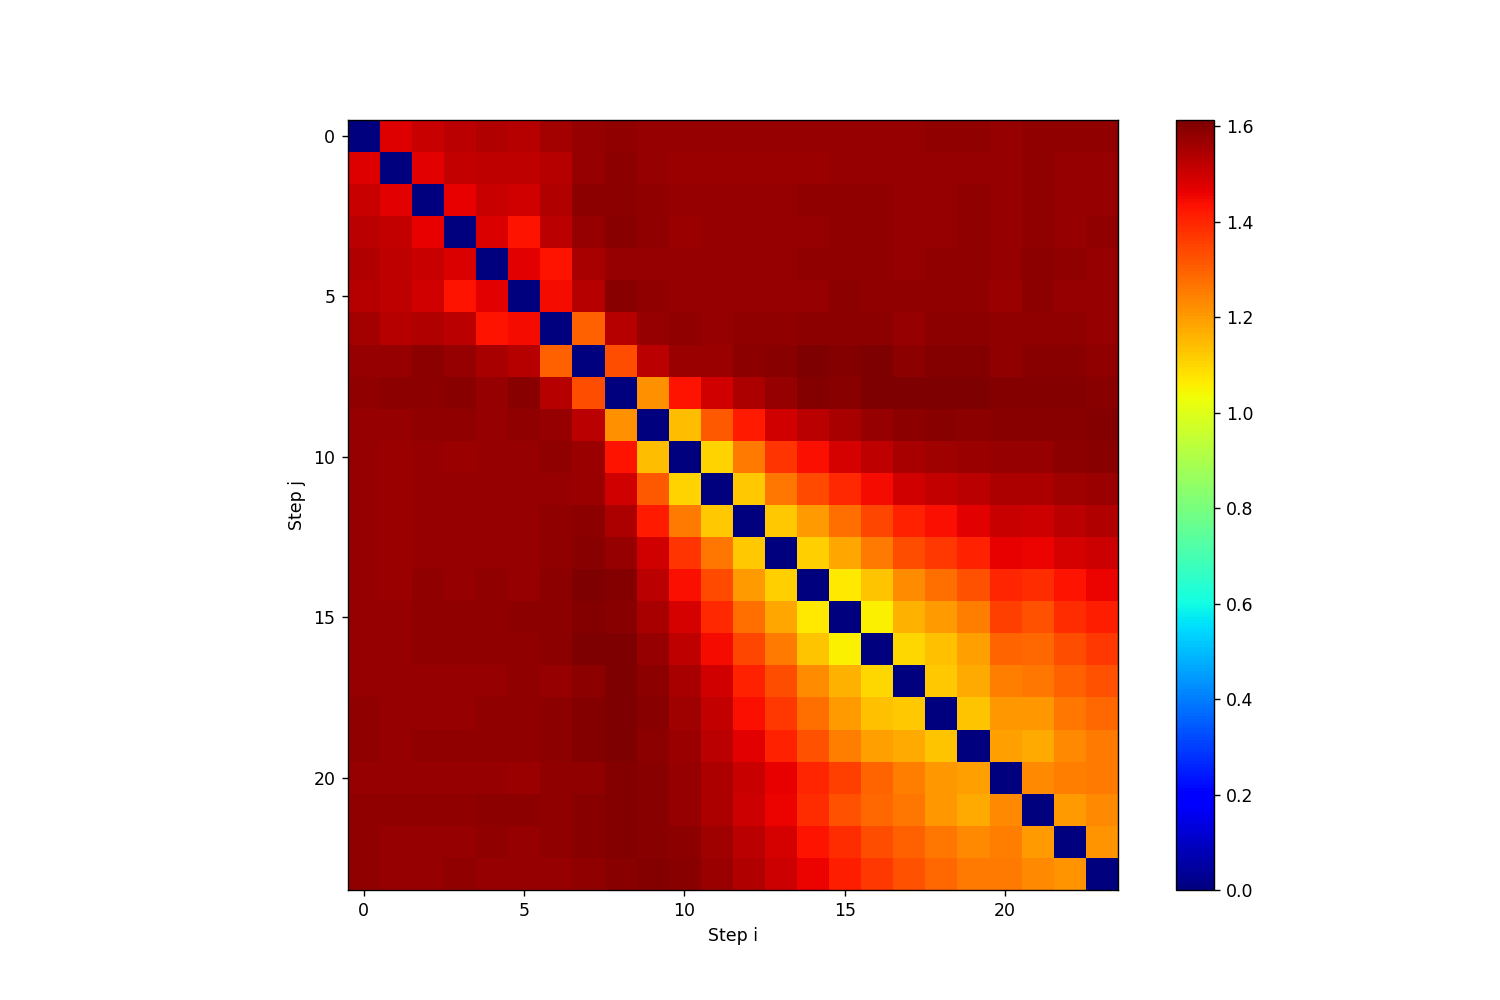

<IPython.core.display.Javascript object>


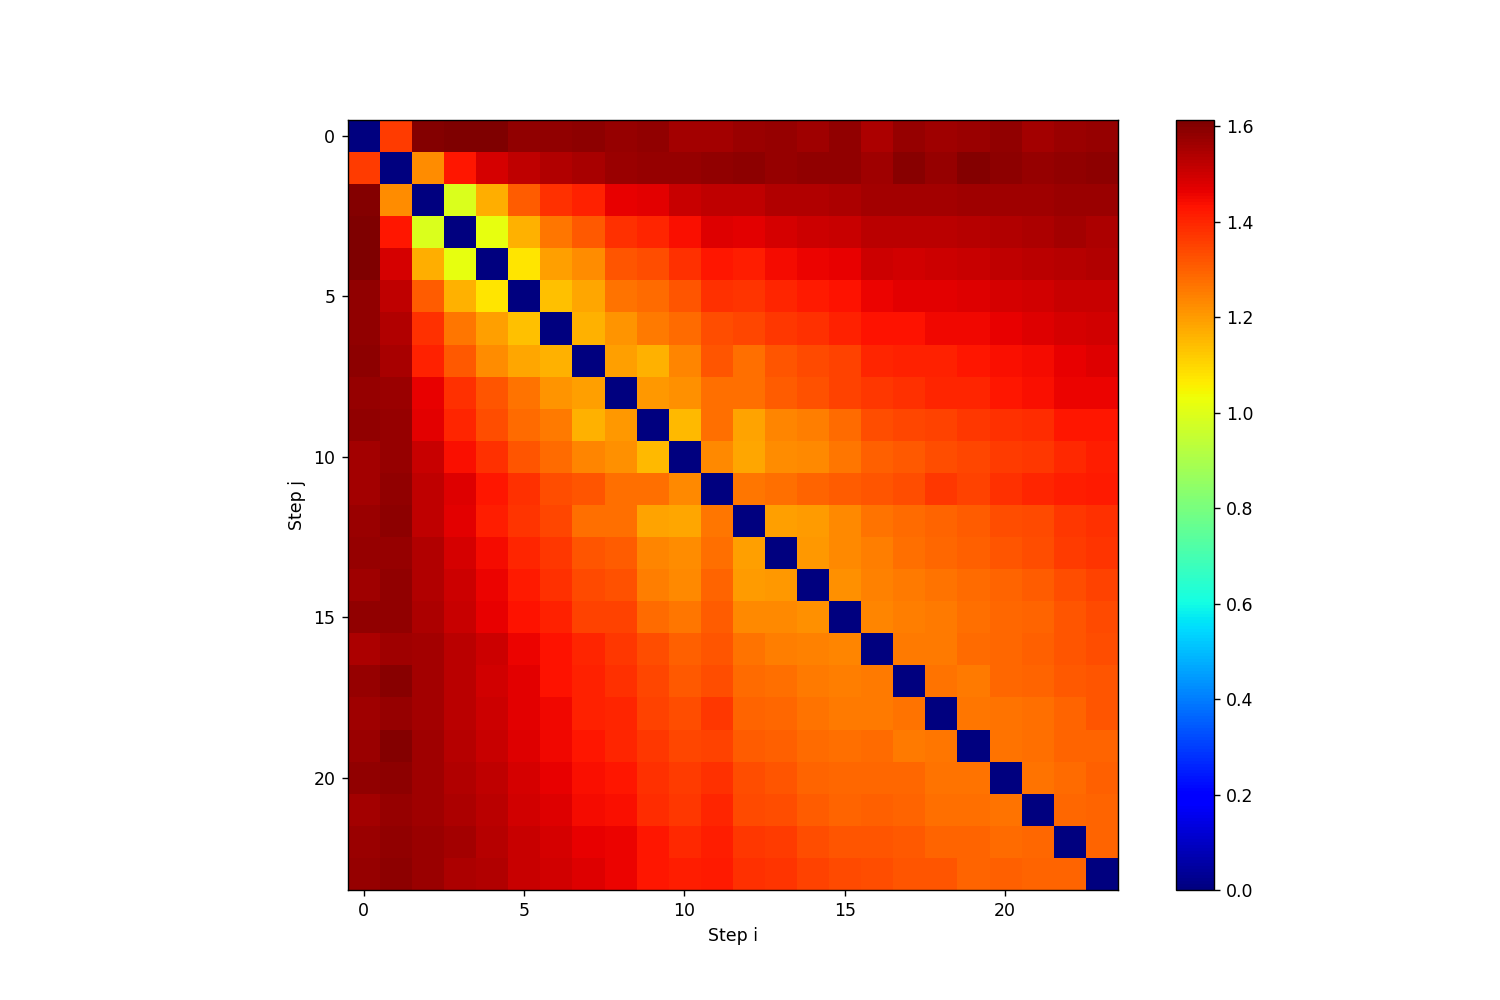

<IPython.core.display.Javascript object>


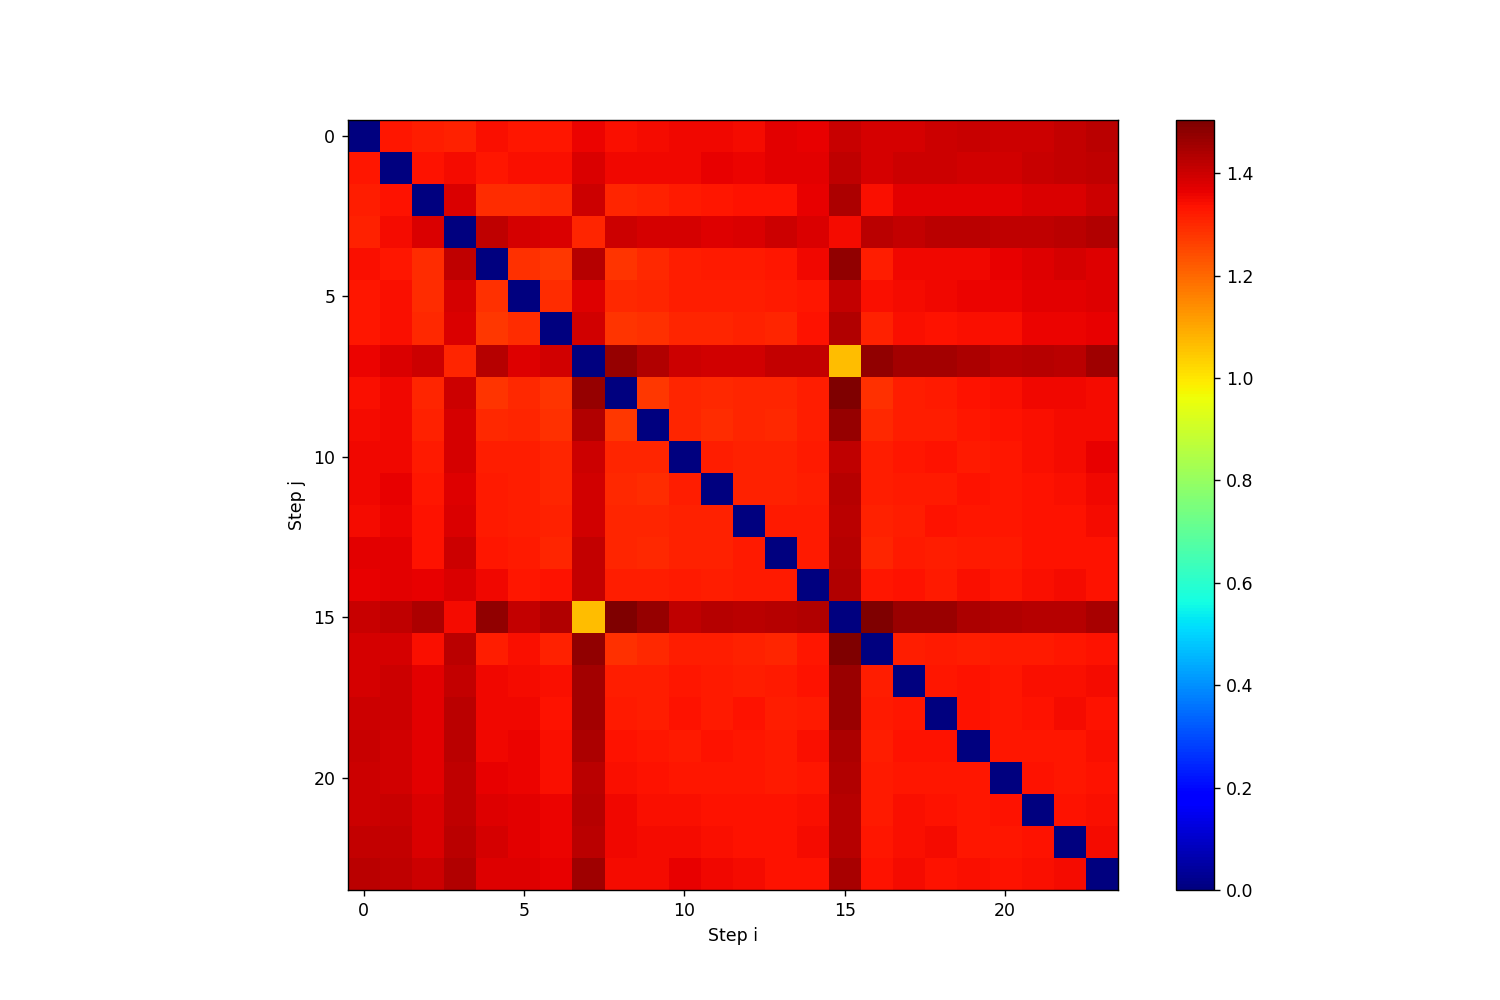

<IPython.core.display.Javascript object>


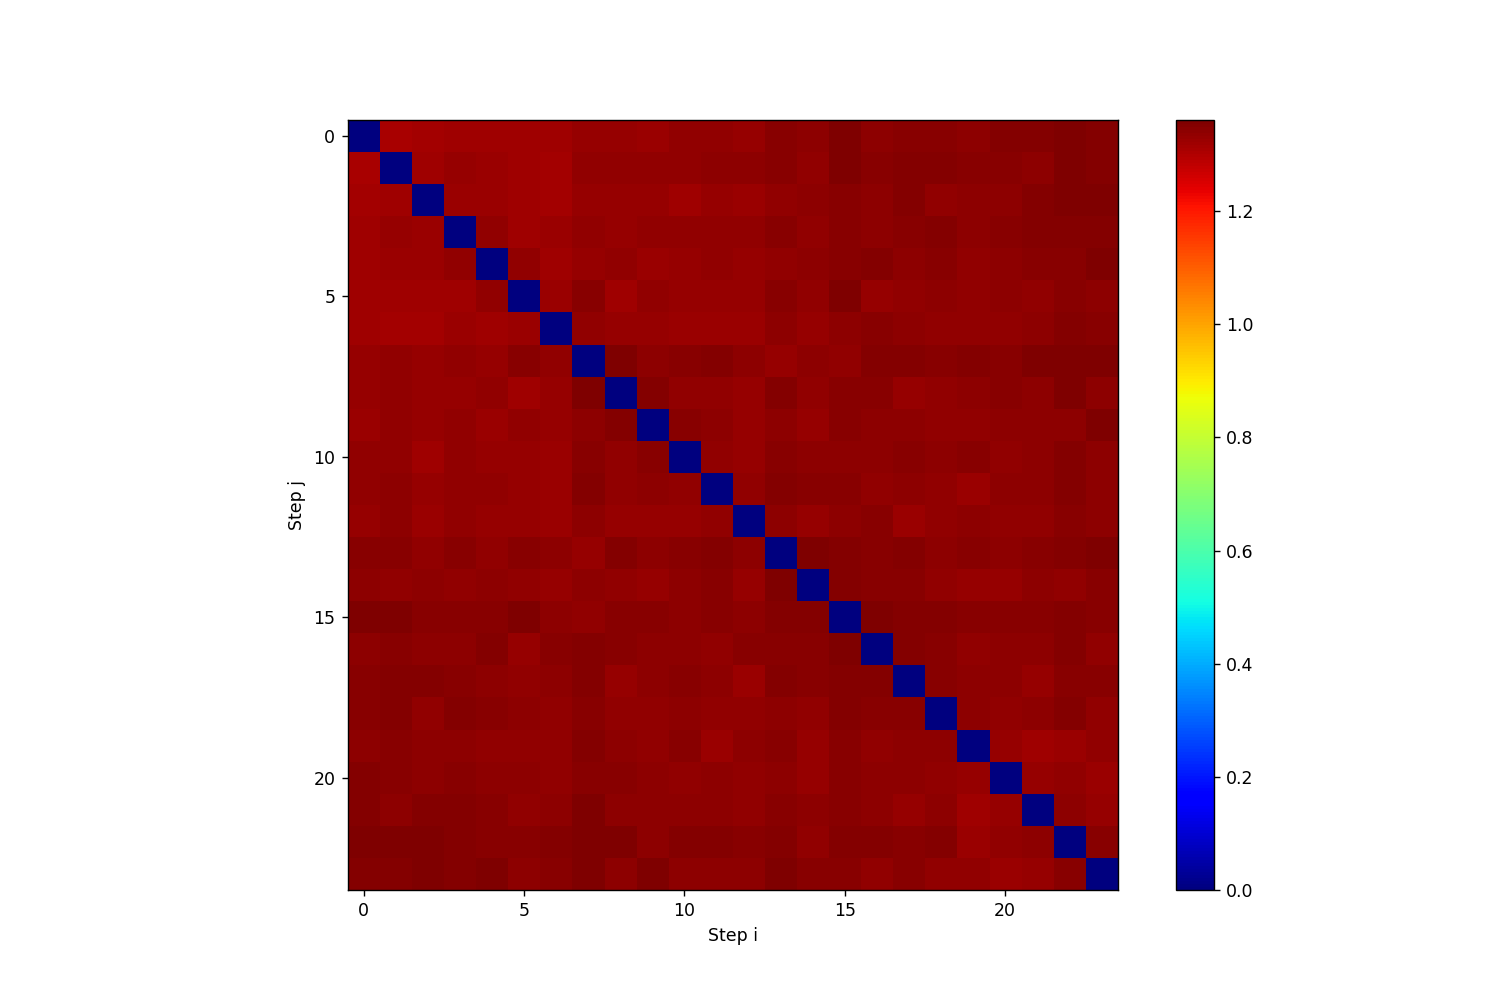

<IPython.core.display.Javascript object>


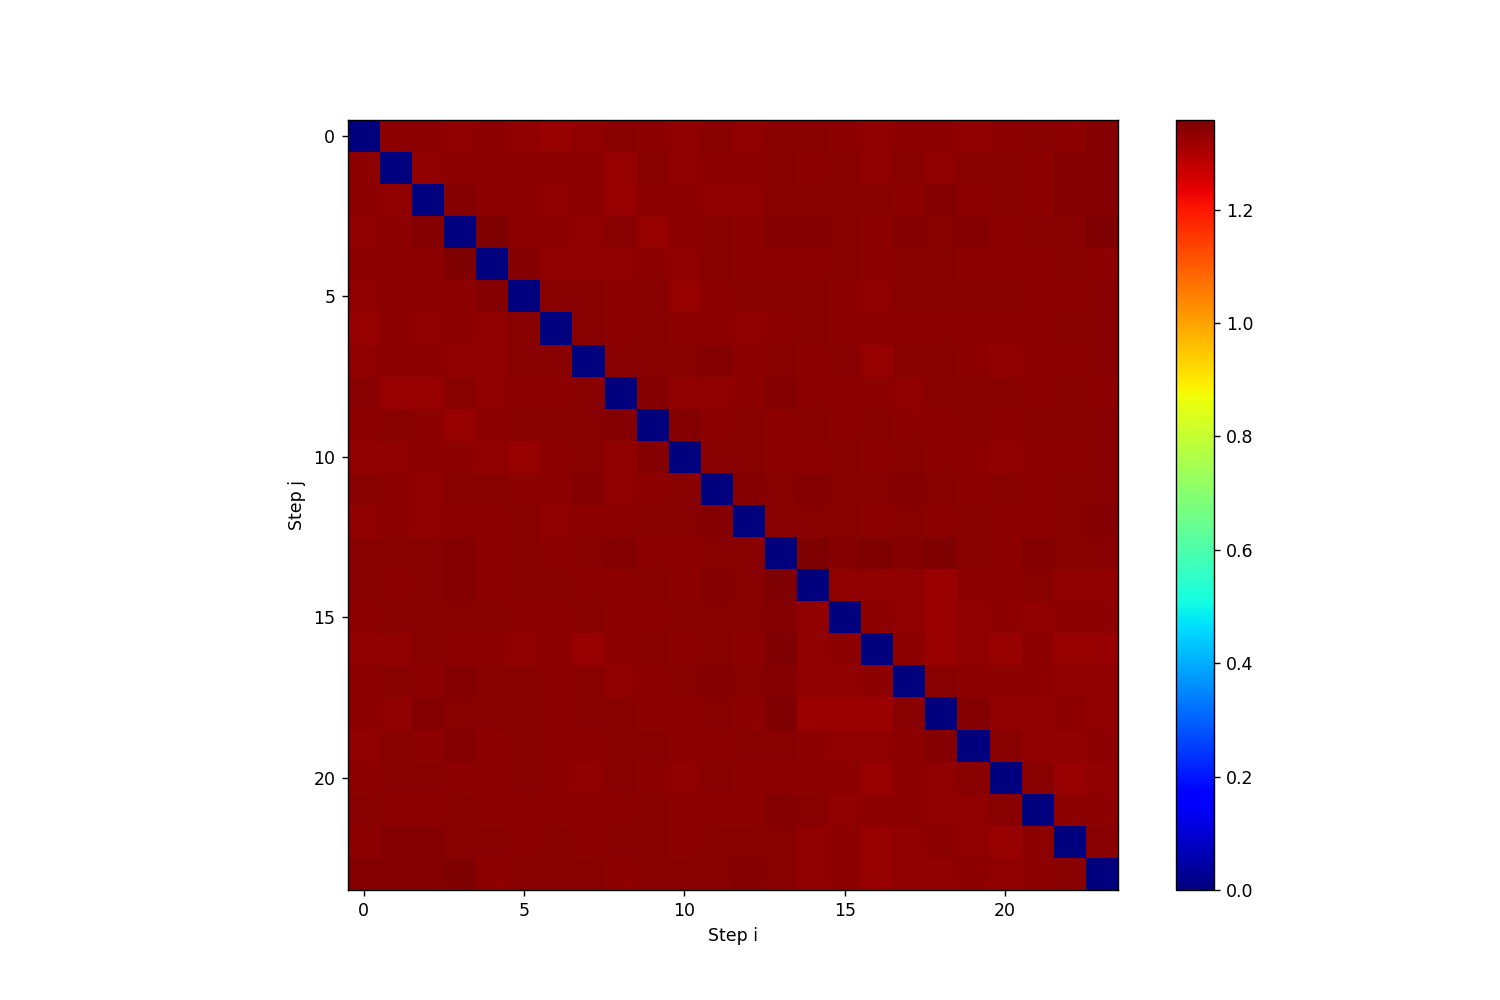

<IPython.core.display.Javascript object>


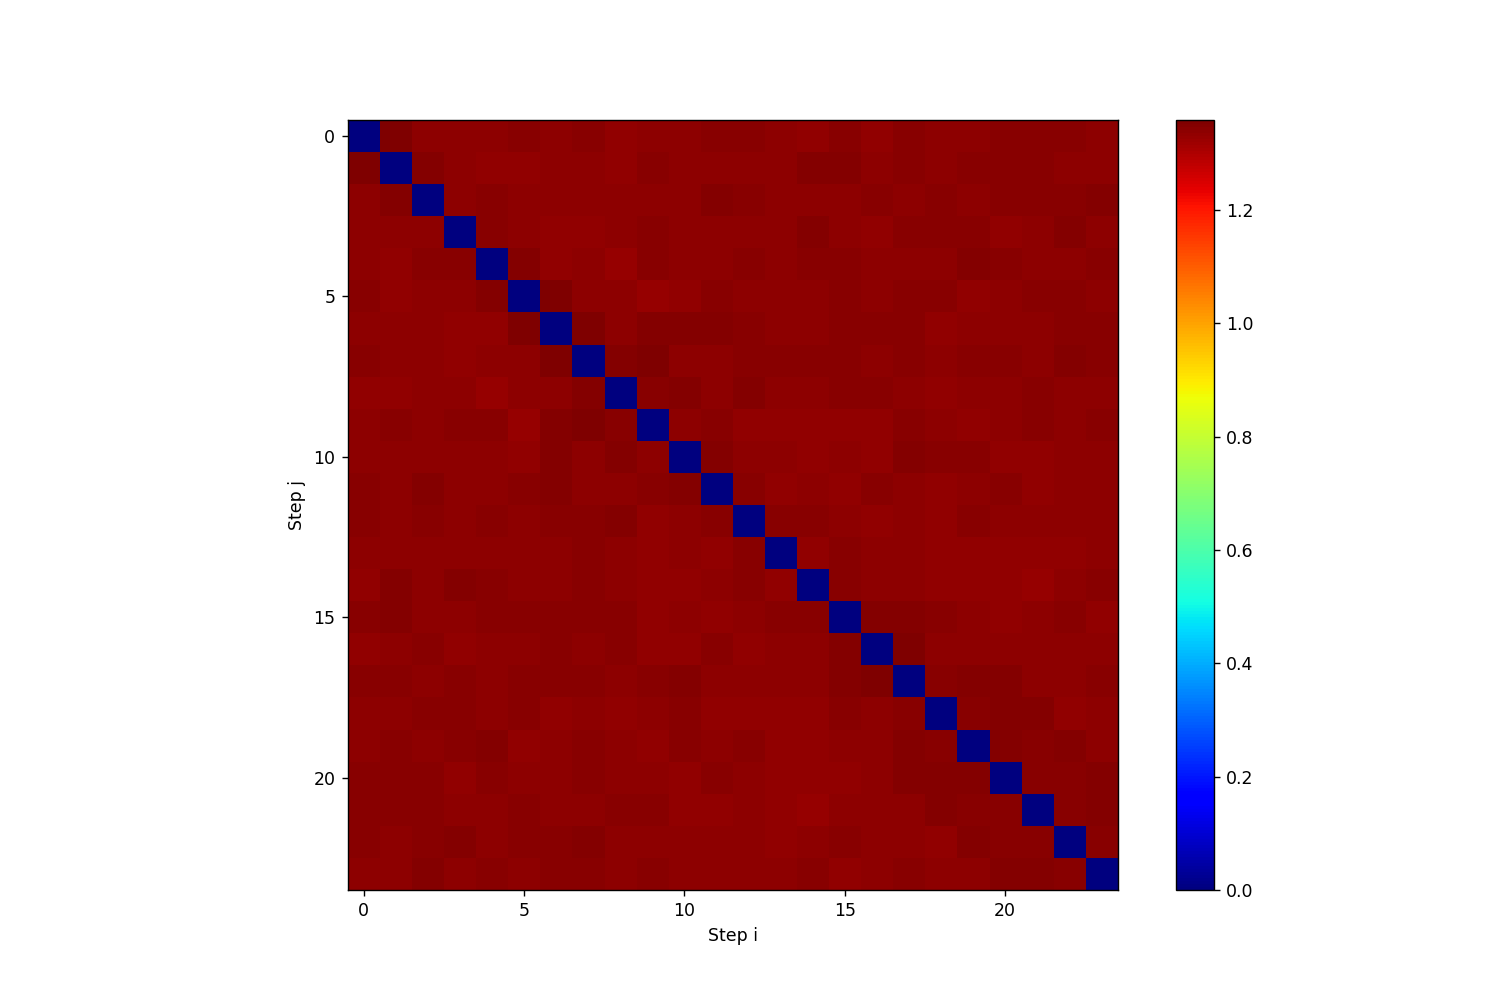

<IPython.core.display.Javascript object>


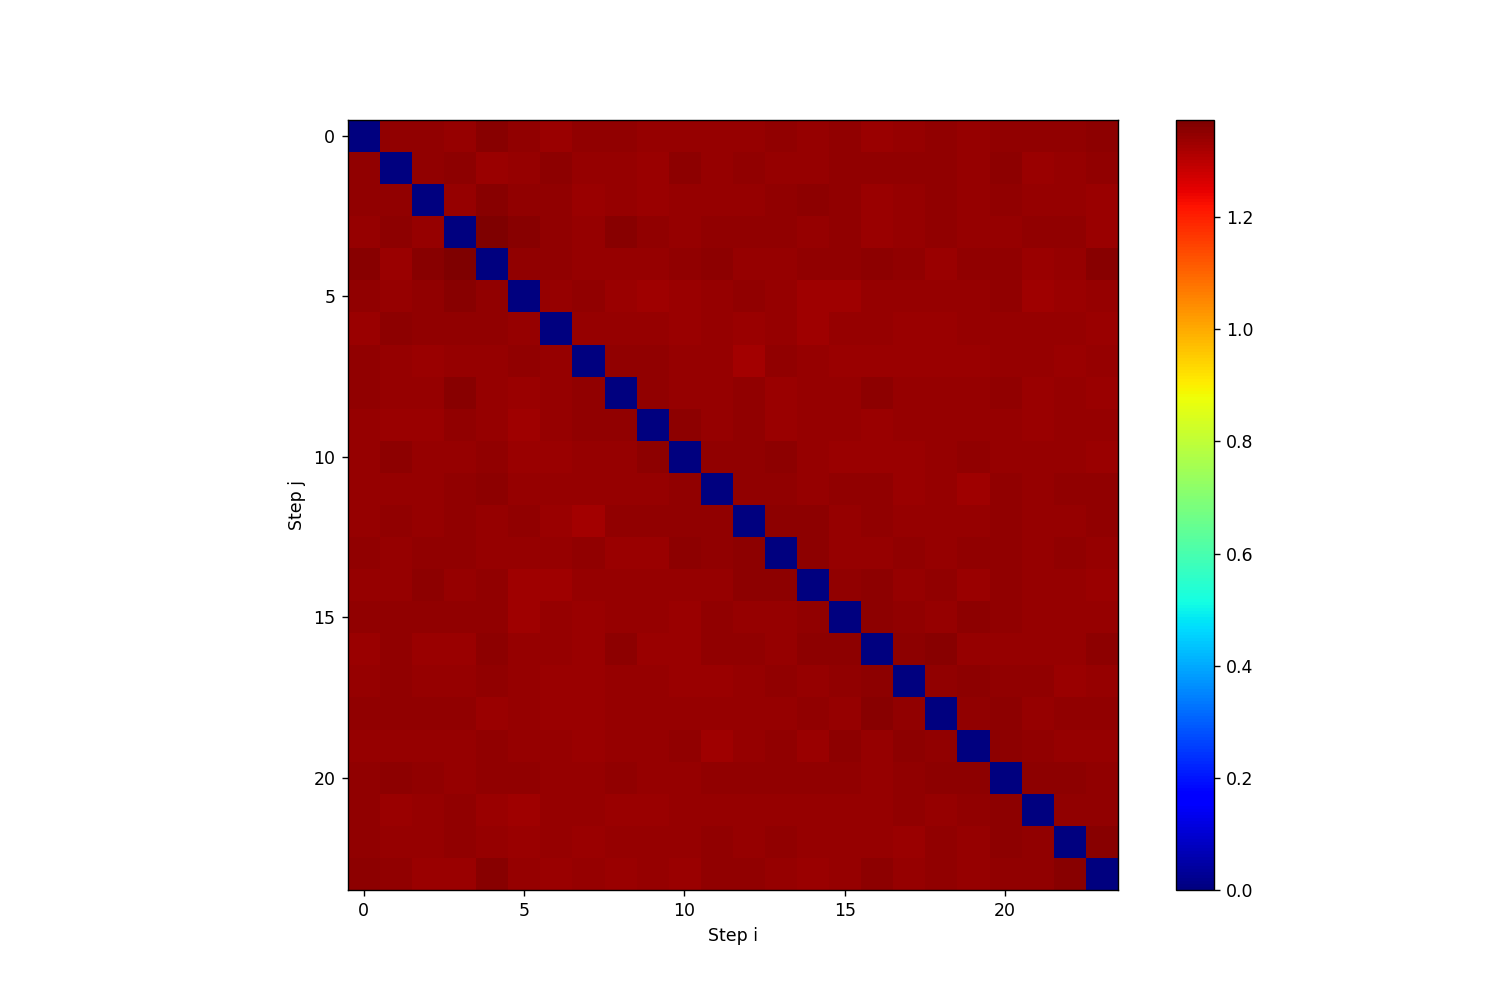

In [22]:
import matplotlib.colors as colors
import matplotlib.cm as cm

for angle_grid in angle_grids:
    plt.figure(figsize=(12,8))
    norm = colors.Normalize(vmin=np.amin(angle_grid), vmax=np.amax(angle_grid))   
    plt.imshow(angle_grid, cmap=cm.jet)
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet))
    plt.xlabel('Step i')
    plt.ylabel('Step j')
    
#print("num params:", len(these_param_states[0]))

In [23]:
from functions.plotting_DDplus_hists import load_data
from functions.utils import vector_to_state_dict

state_dicts = []
# num_epochs = 500
for i in np.arange(0, num_epochs, 10):
    state_dicts.append( (i, vector_to_state_dict(param_states[i], model)) )

data = load_data()

Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1][0] =  7.8608756
minorAxis_1[iTrk][2][0] =  -2.6228399e-08
minorAxis_2[iTrk][0][0] =  7.860759
minorAxis_2[iTrk][1][0] =  15.822513
minorAxis_2[iTrk][2][0] =  0.096502915
  
majorAxis[iTrk][0][0] =  -0.37655562
majorAxis[iTrk][1][0] =  0.2768704
majorAxis[iTrk][2][0] = 

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]


<IPython.core.display.Javascript object>


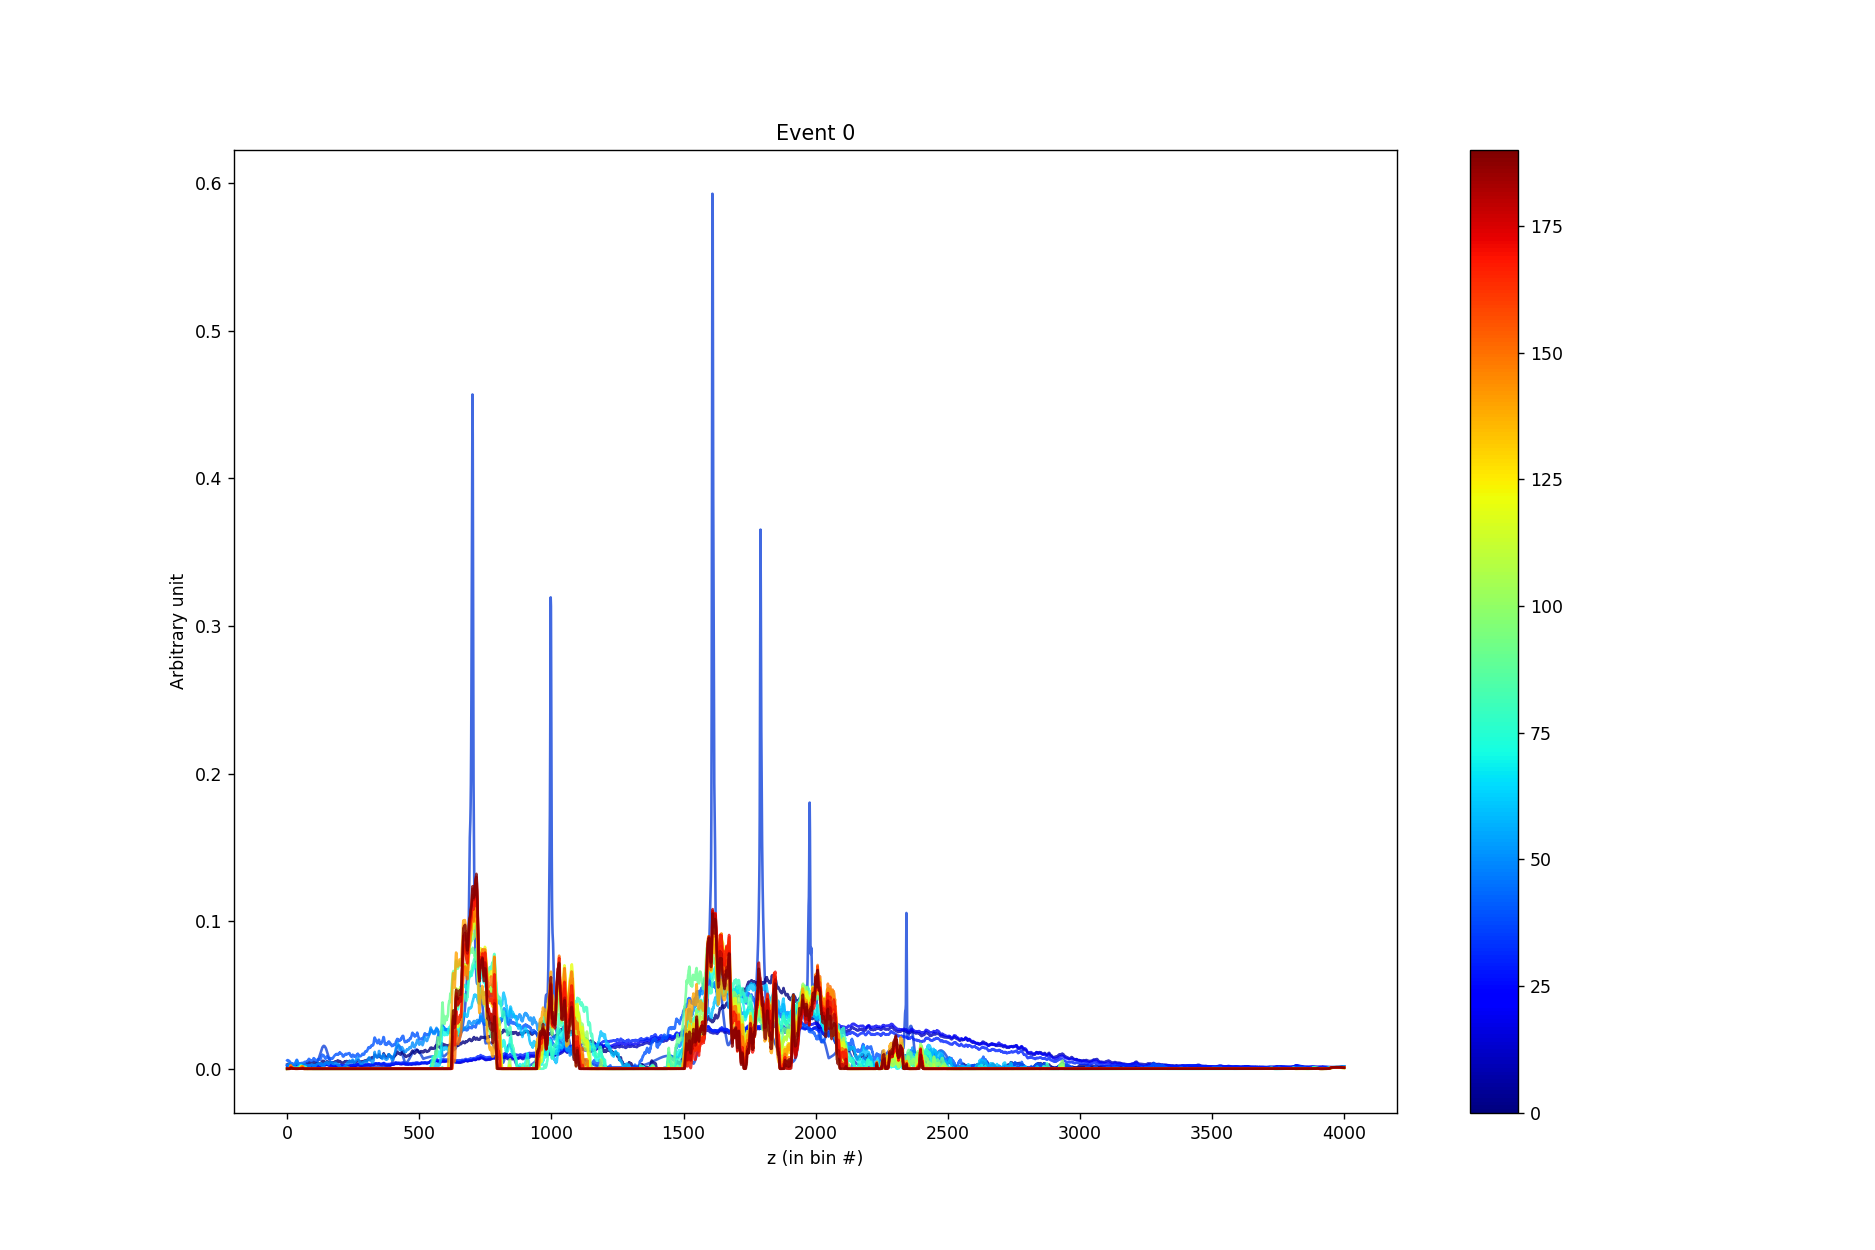

<IPython.core.display.Javascript object>


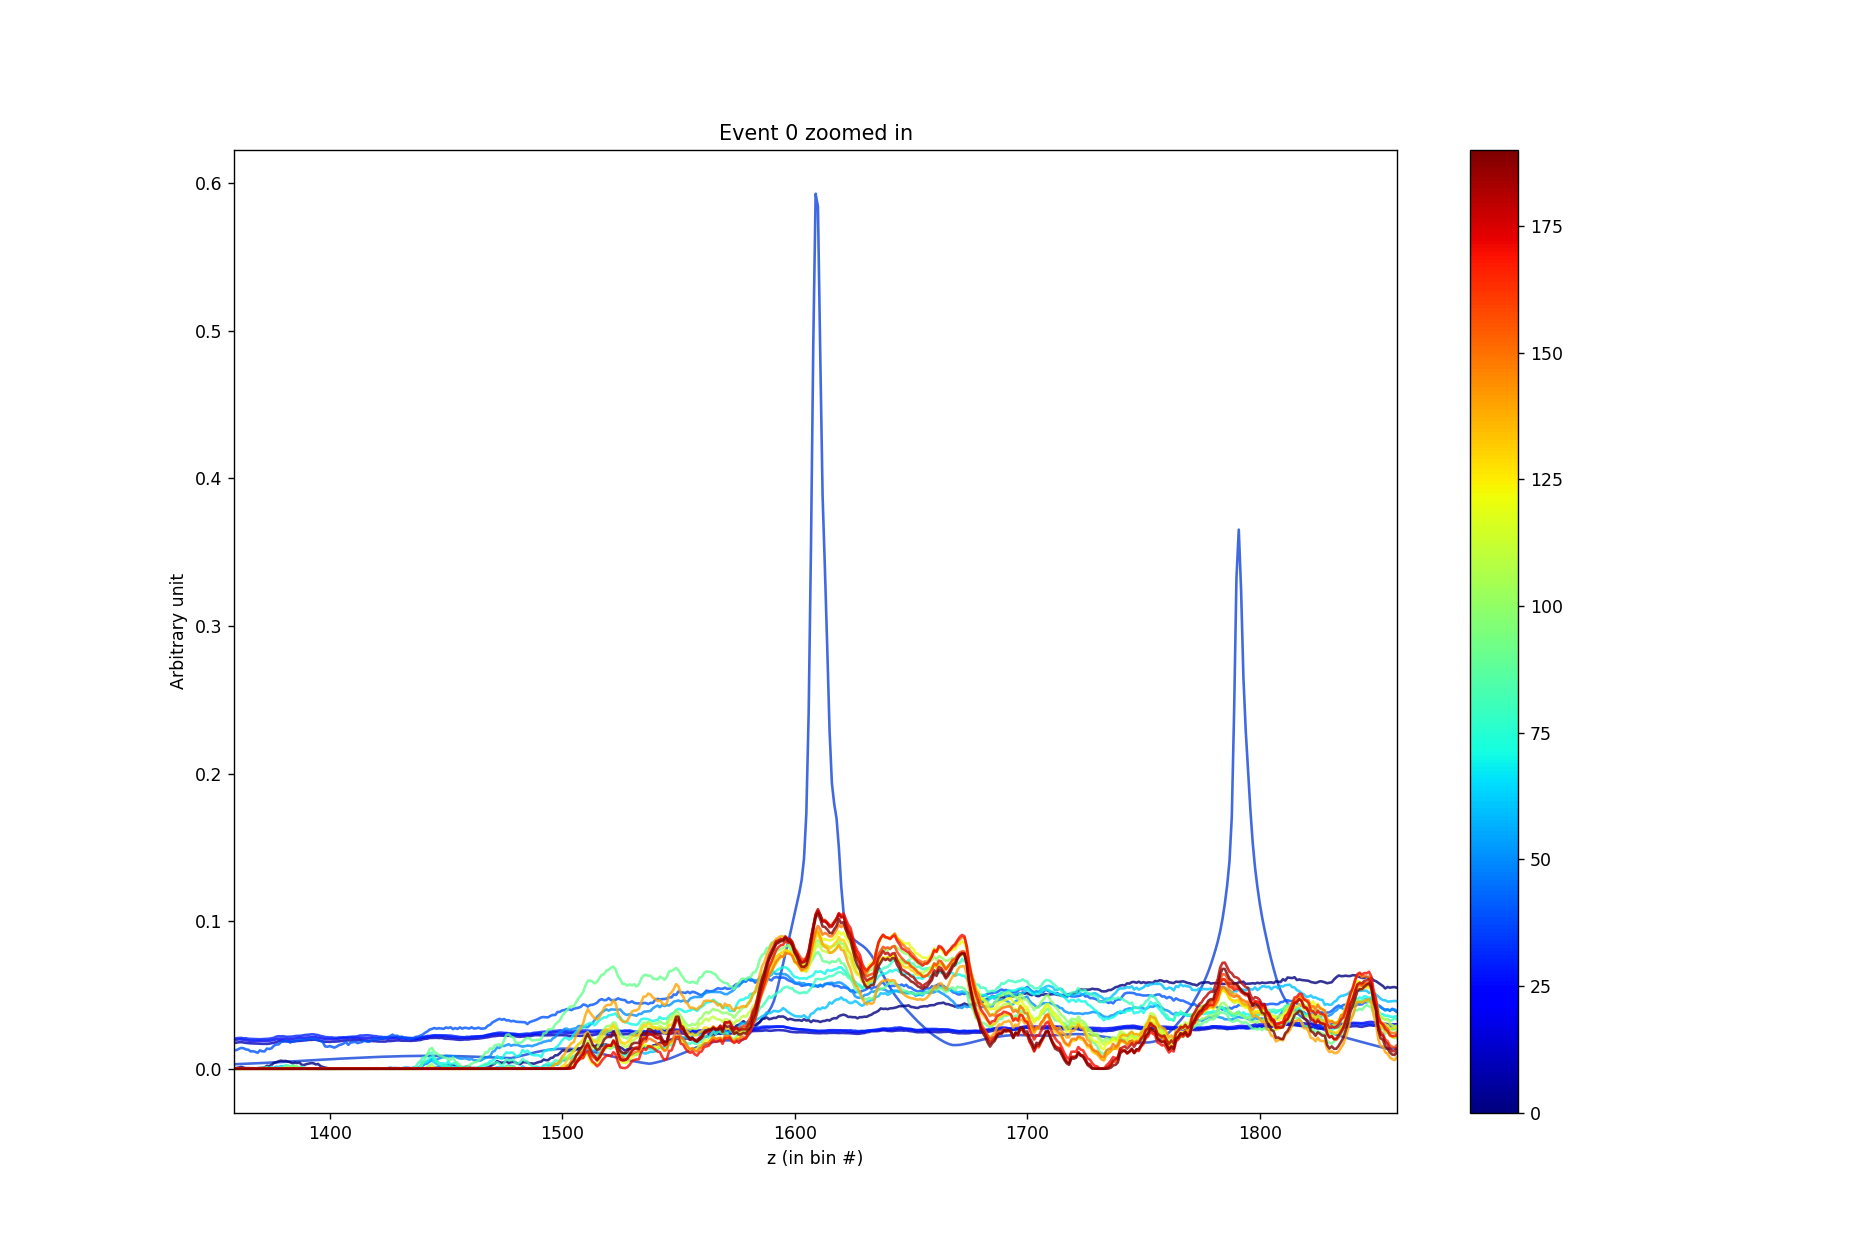

<IPython.core.display.Javascript object>


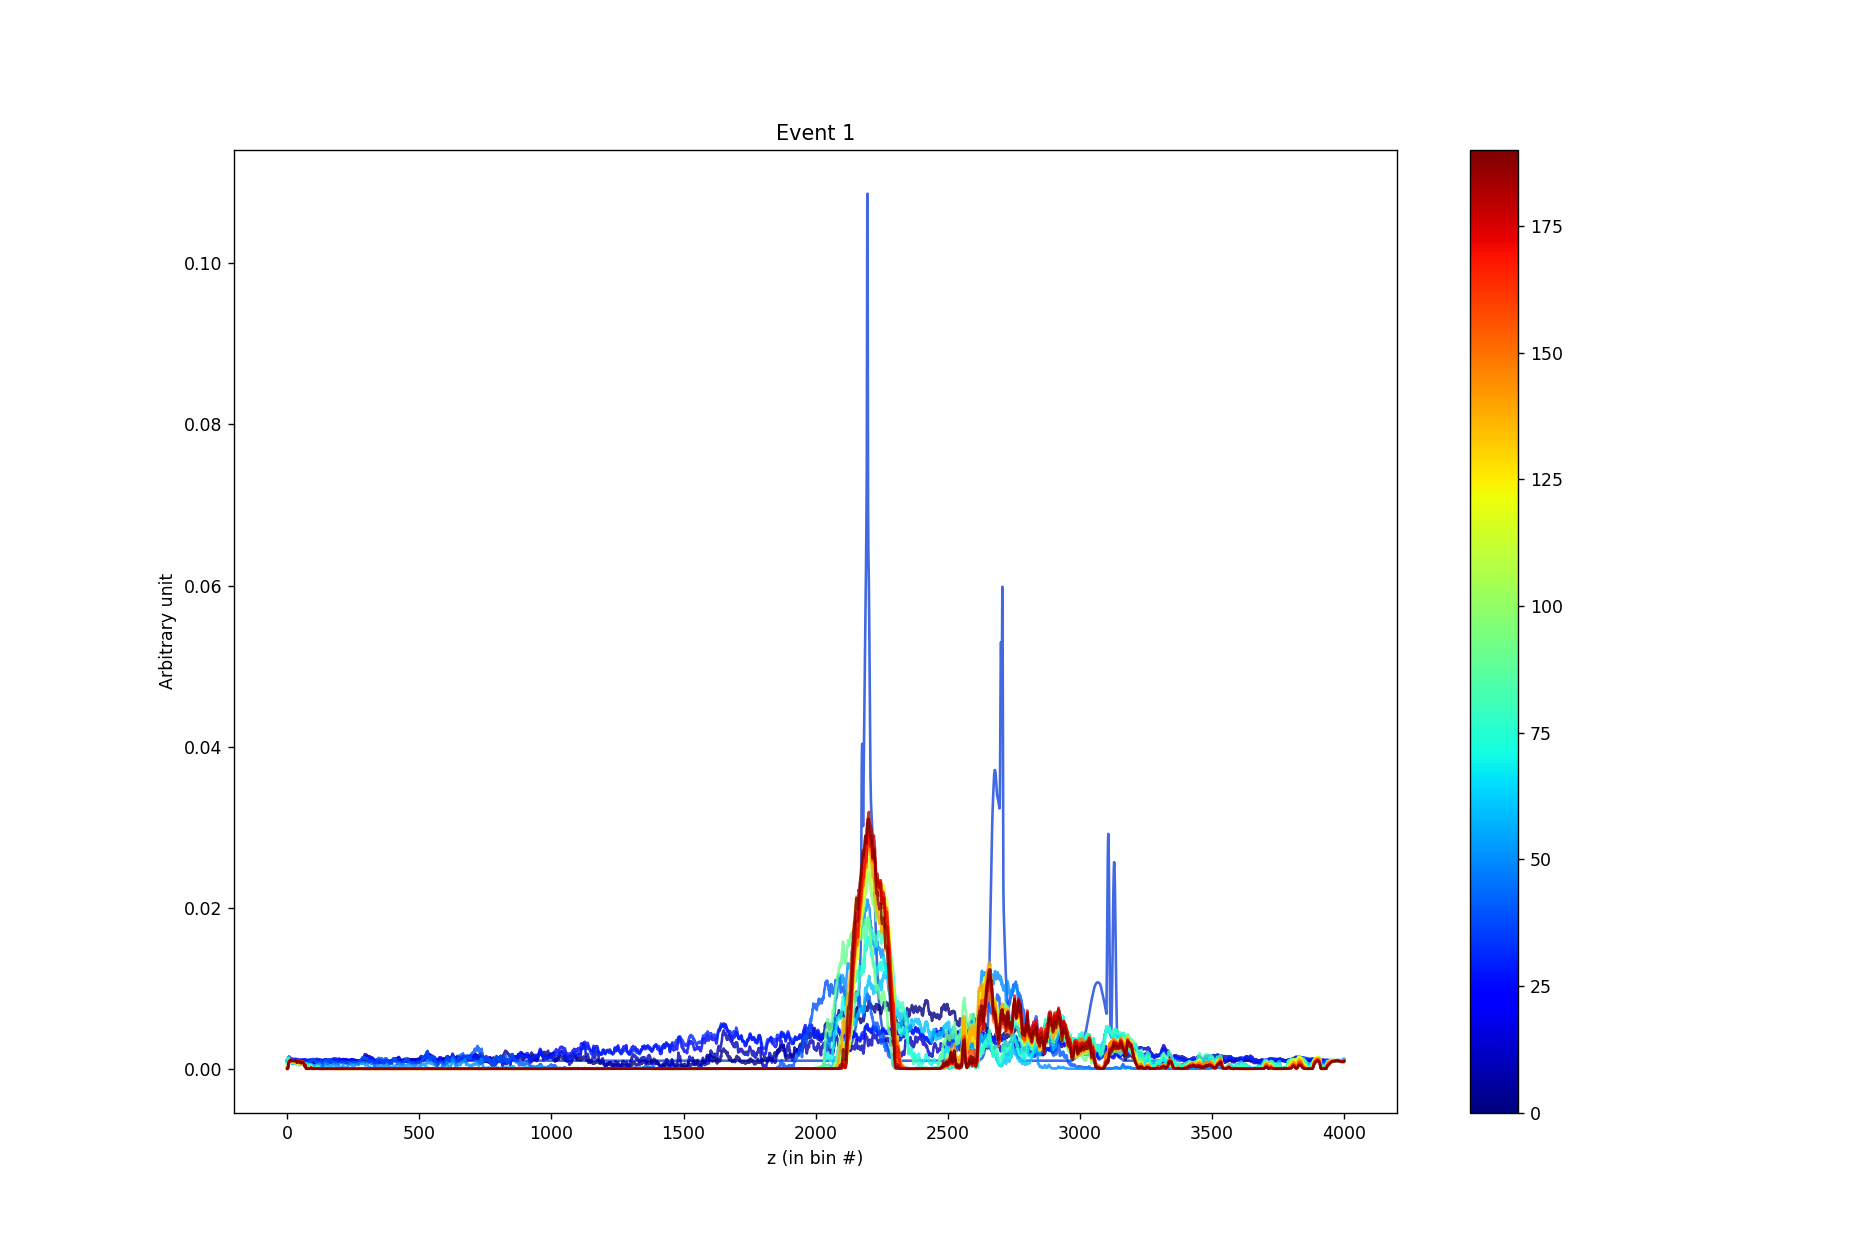

<IPython.core.display.Javascript object>


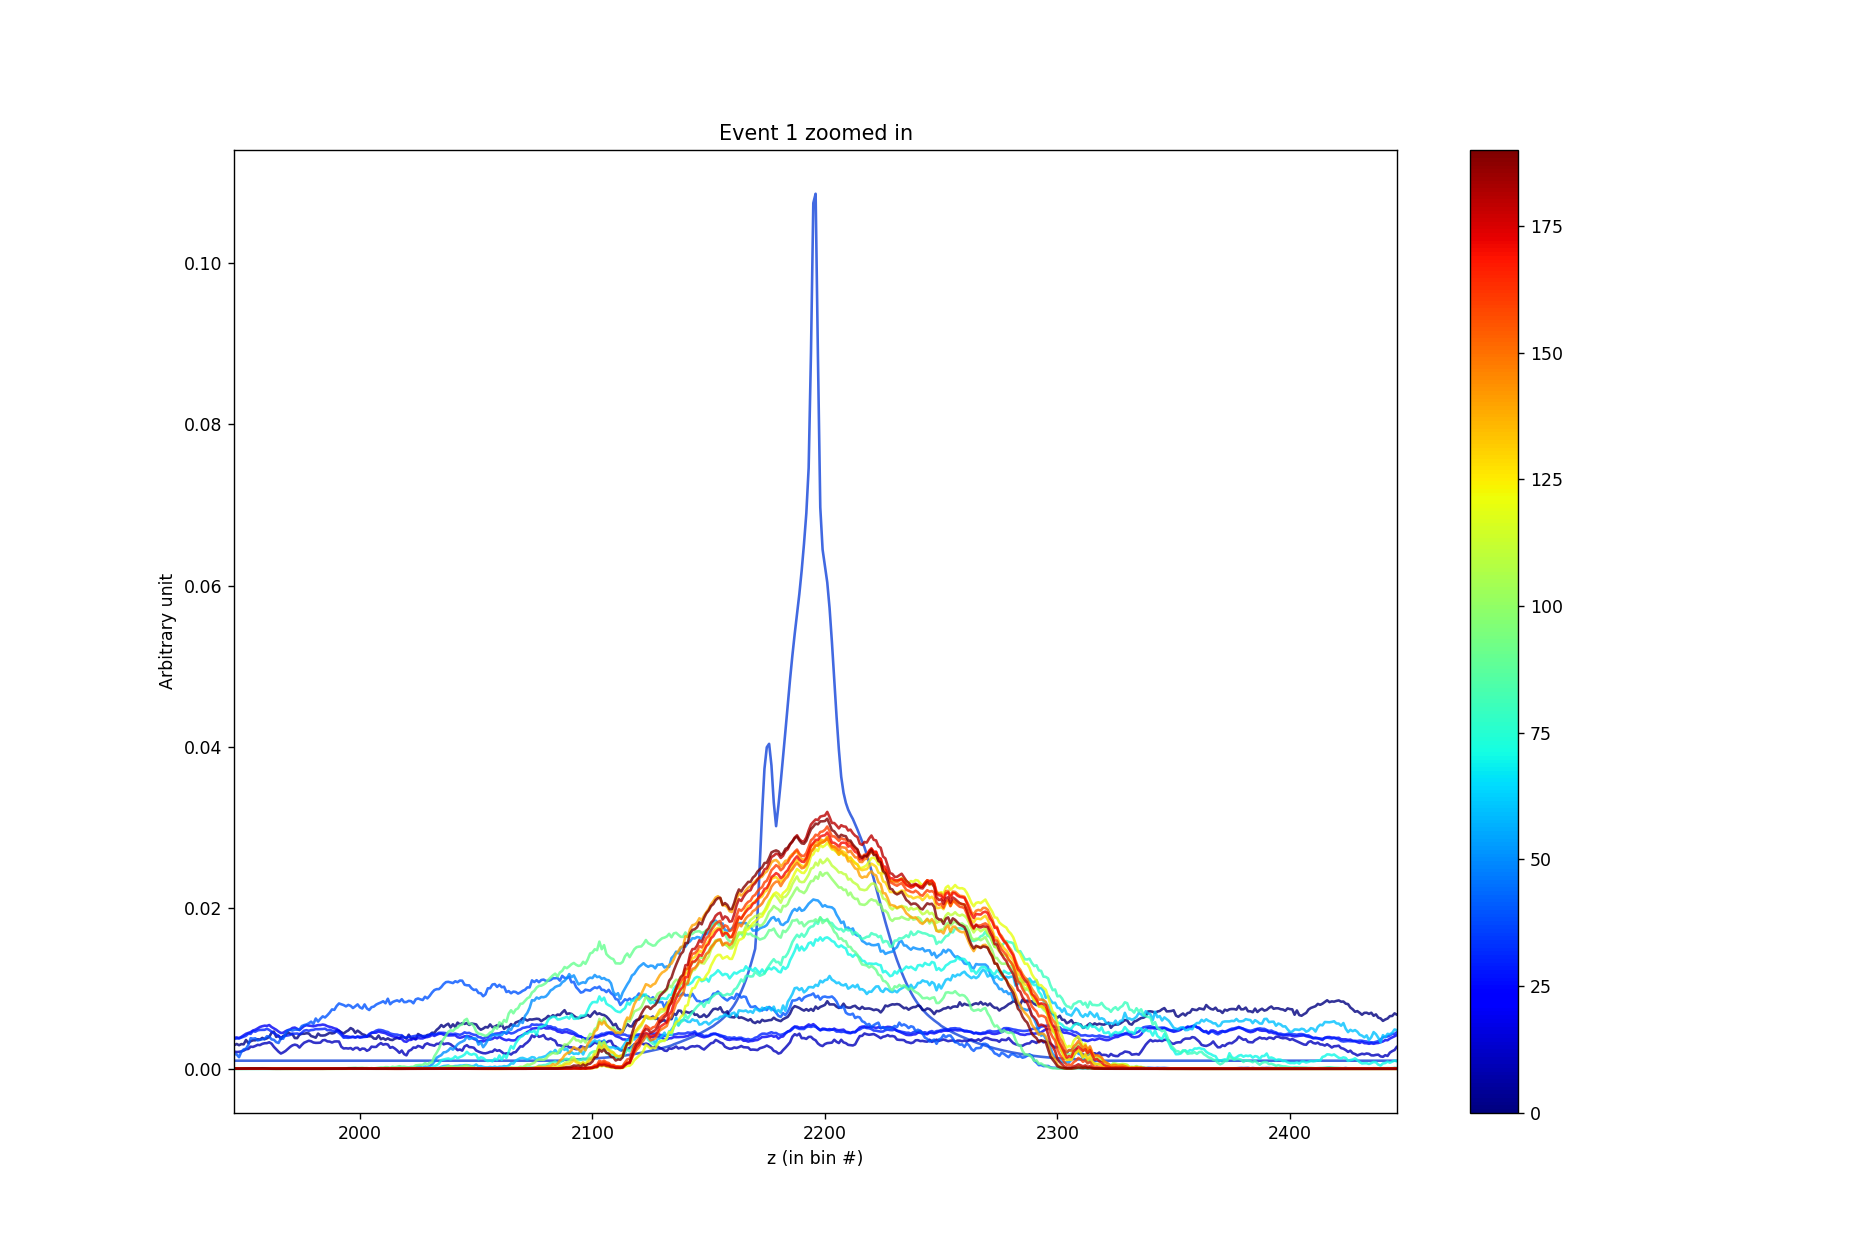

<IPython.core.display.Javascript object>


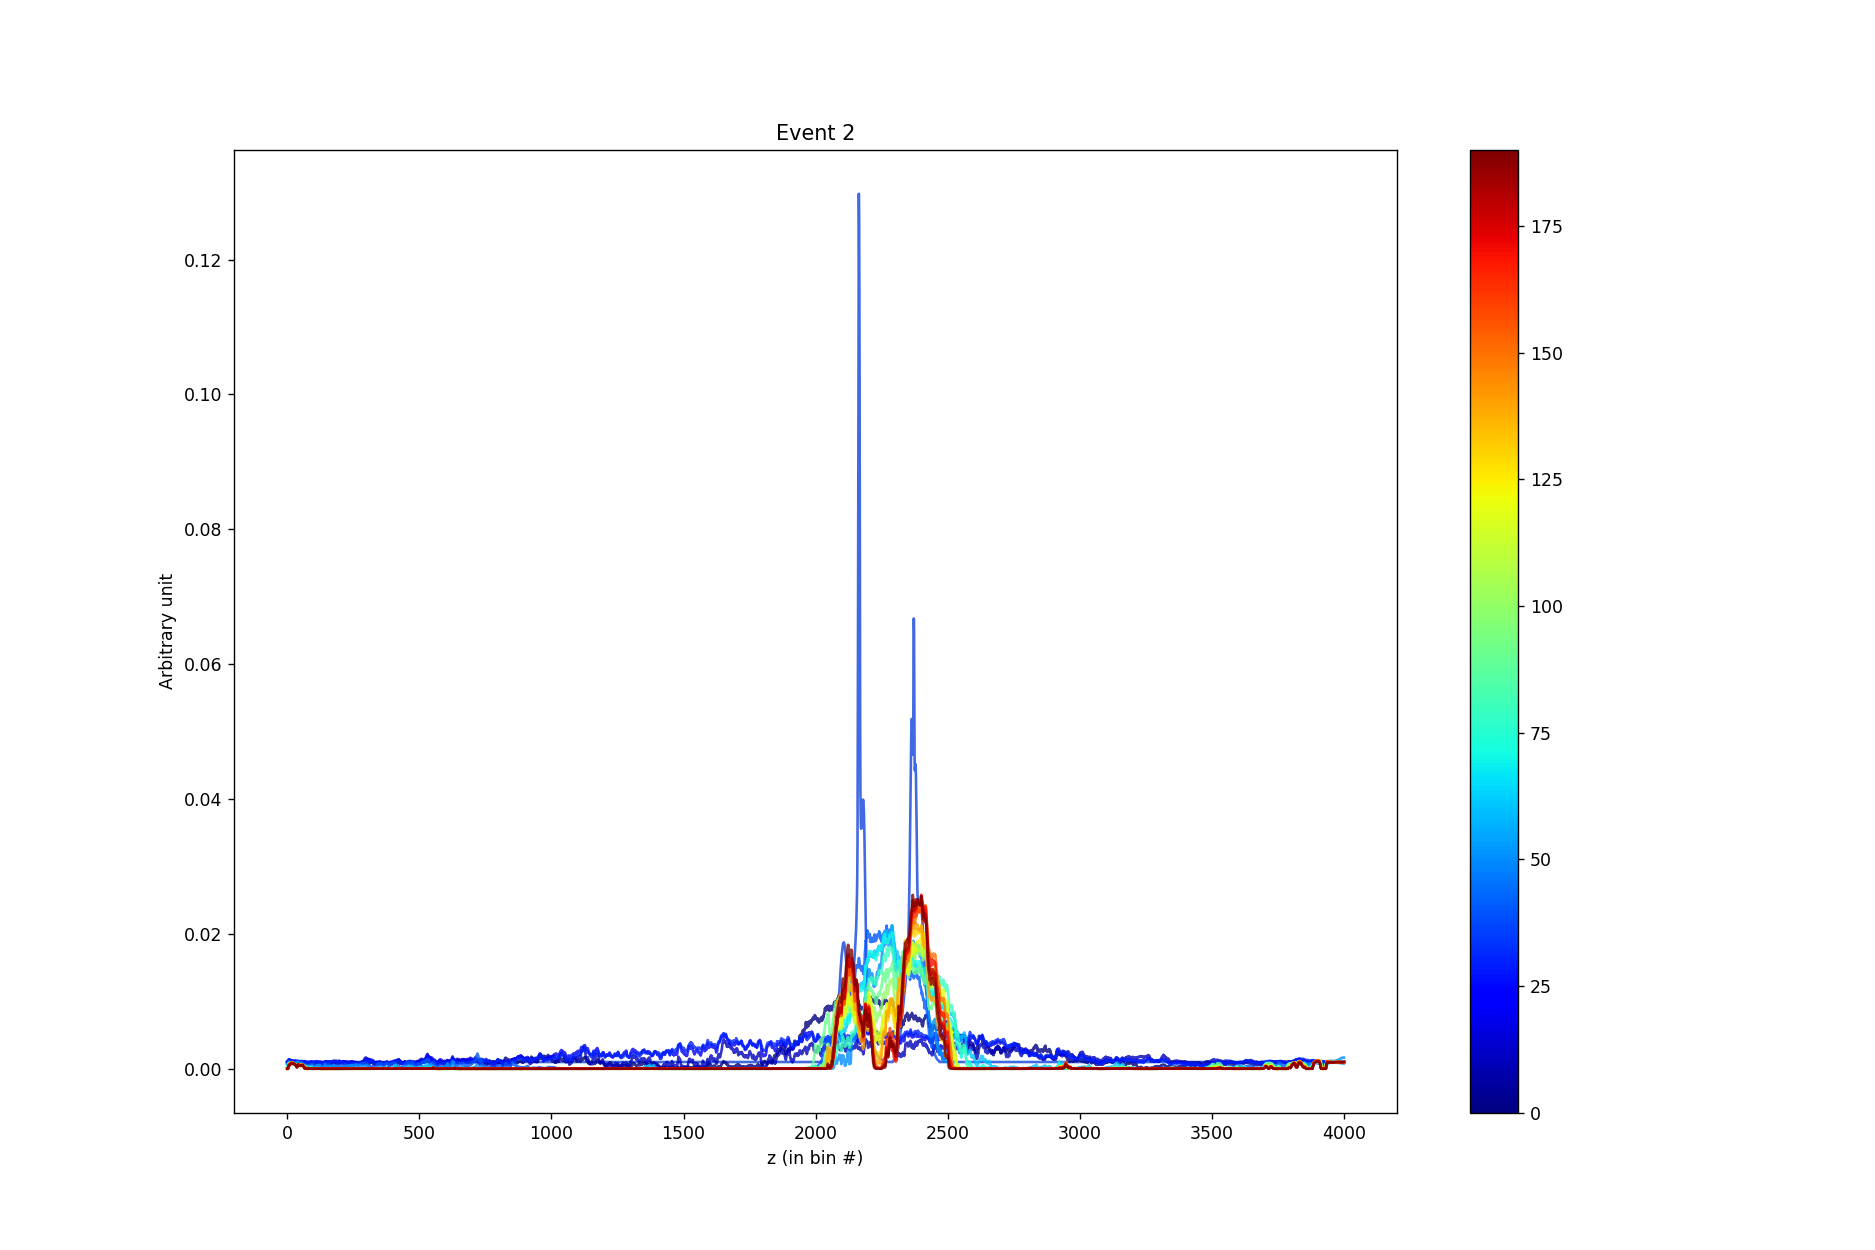

<IPython.core.display.Javascript object>


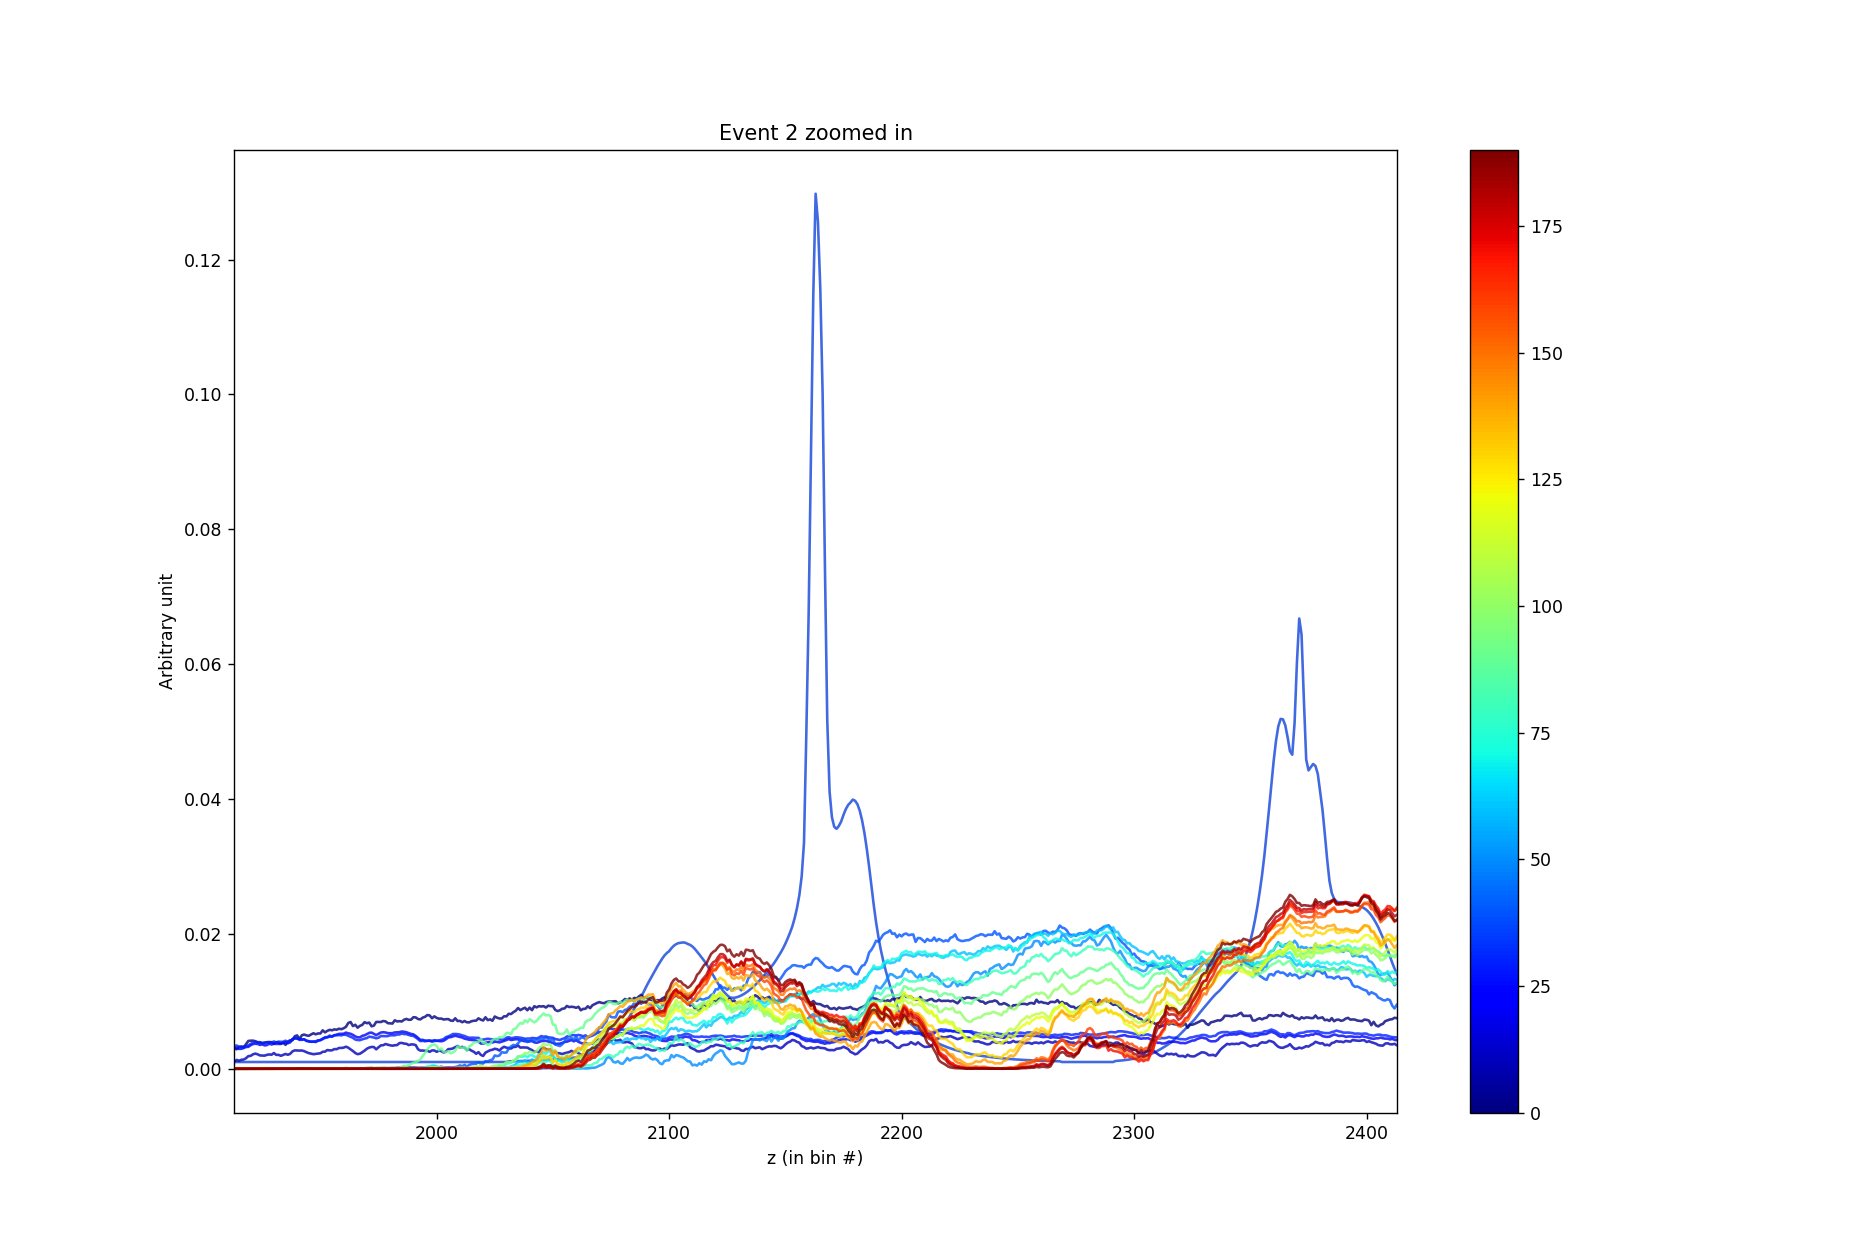

<IPython.core.display.Javascript object>


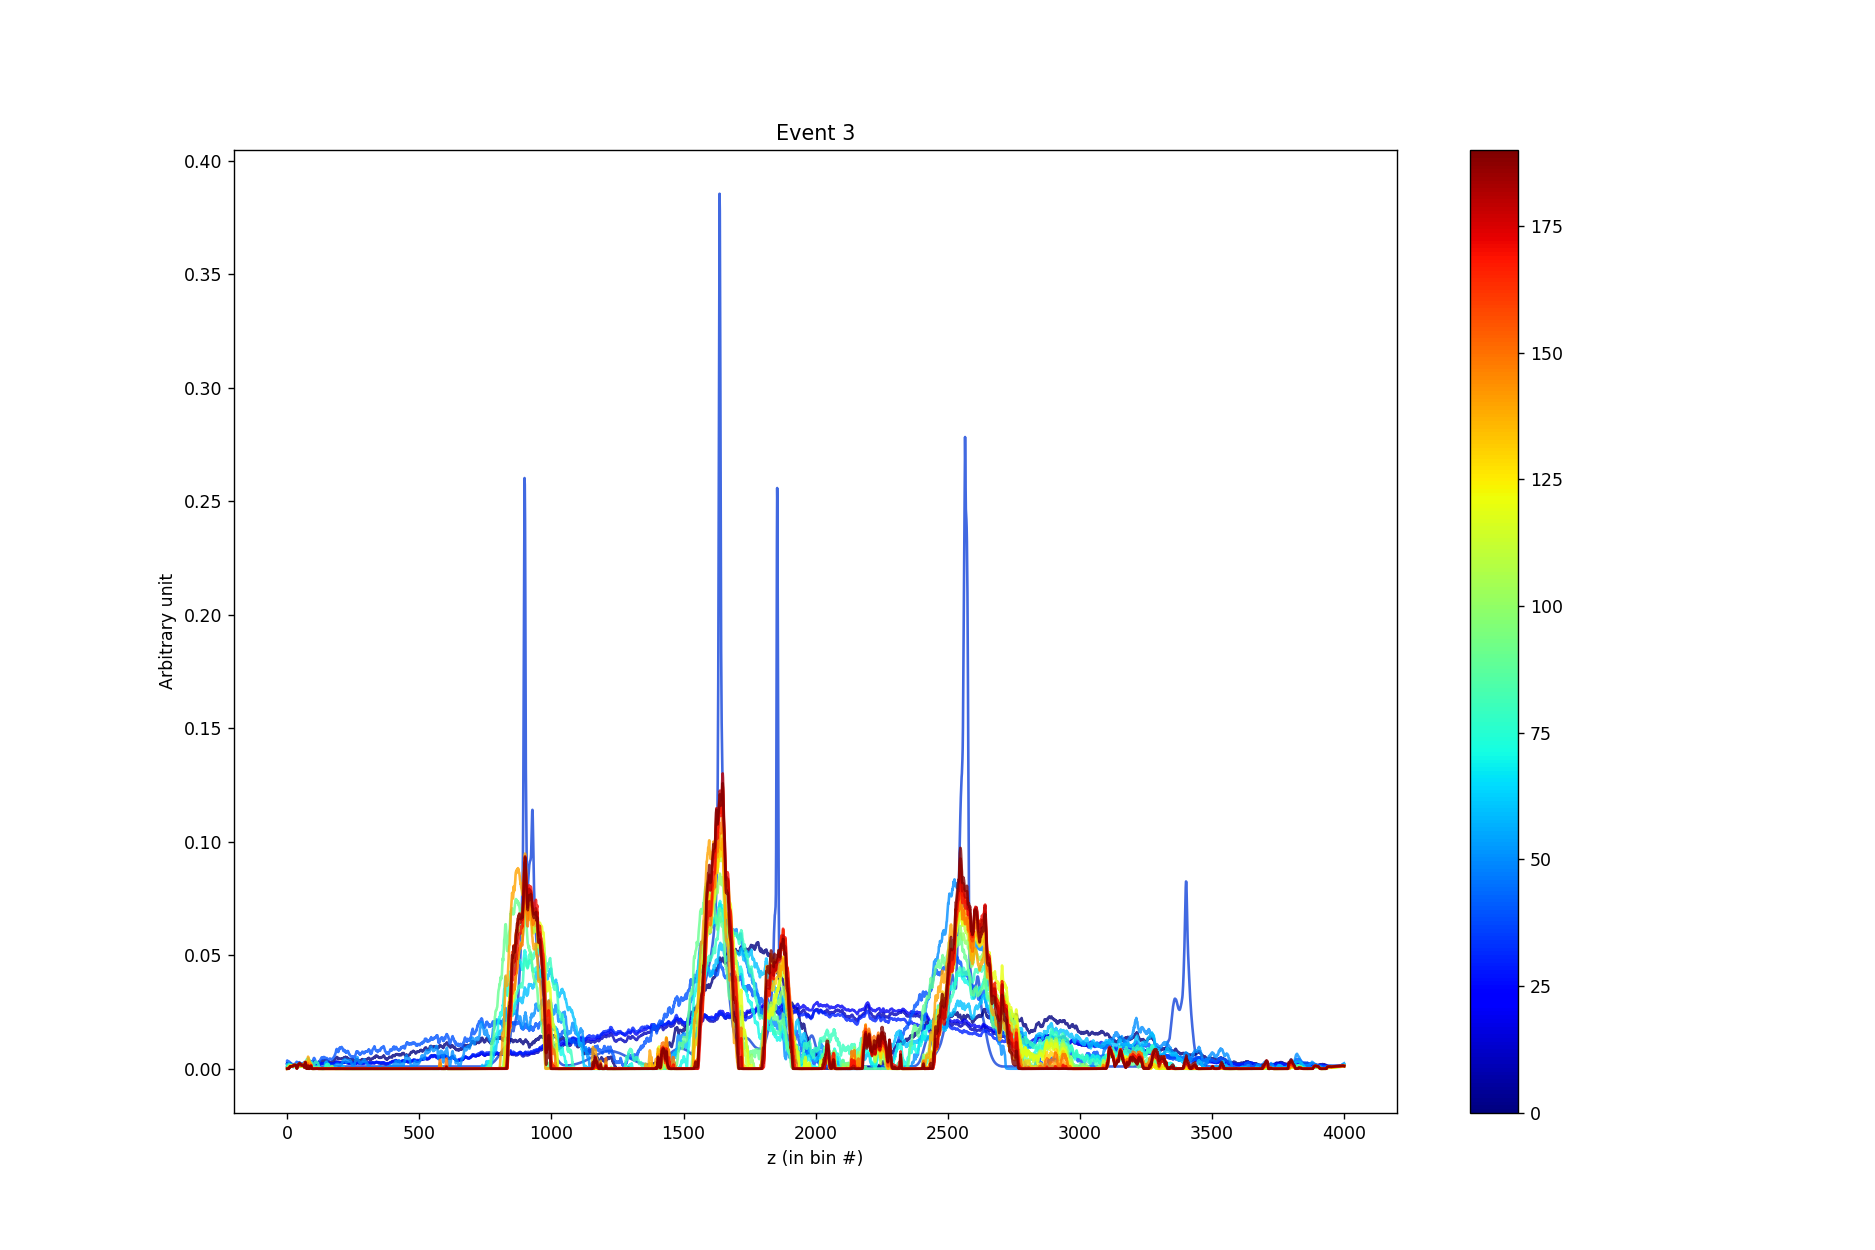

<IPython.core.display.Javascript object>


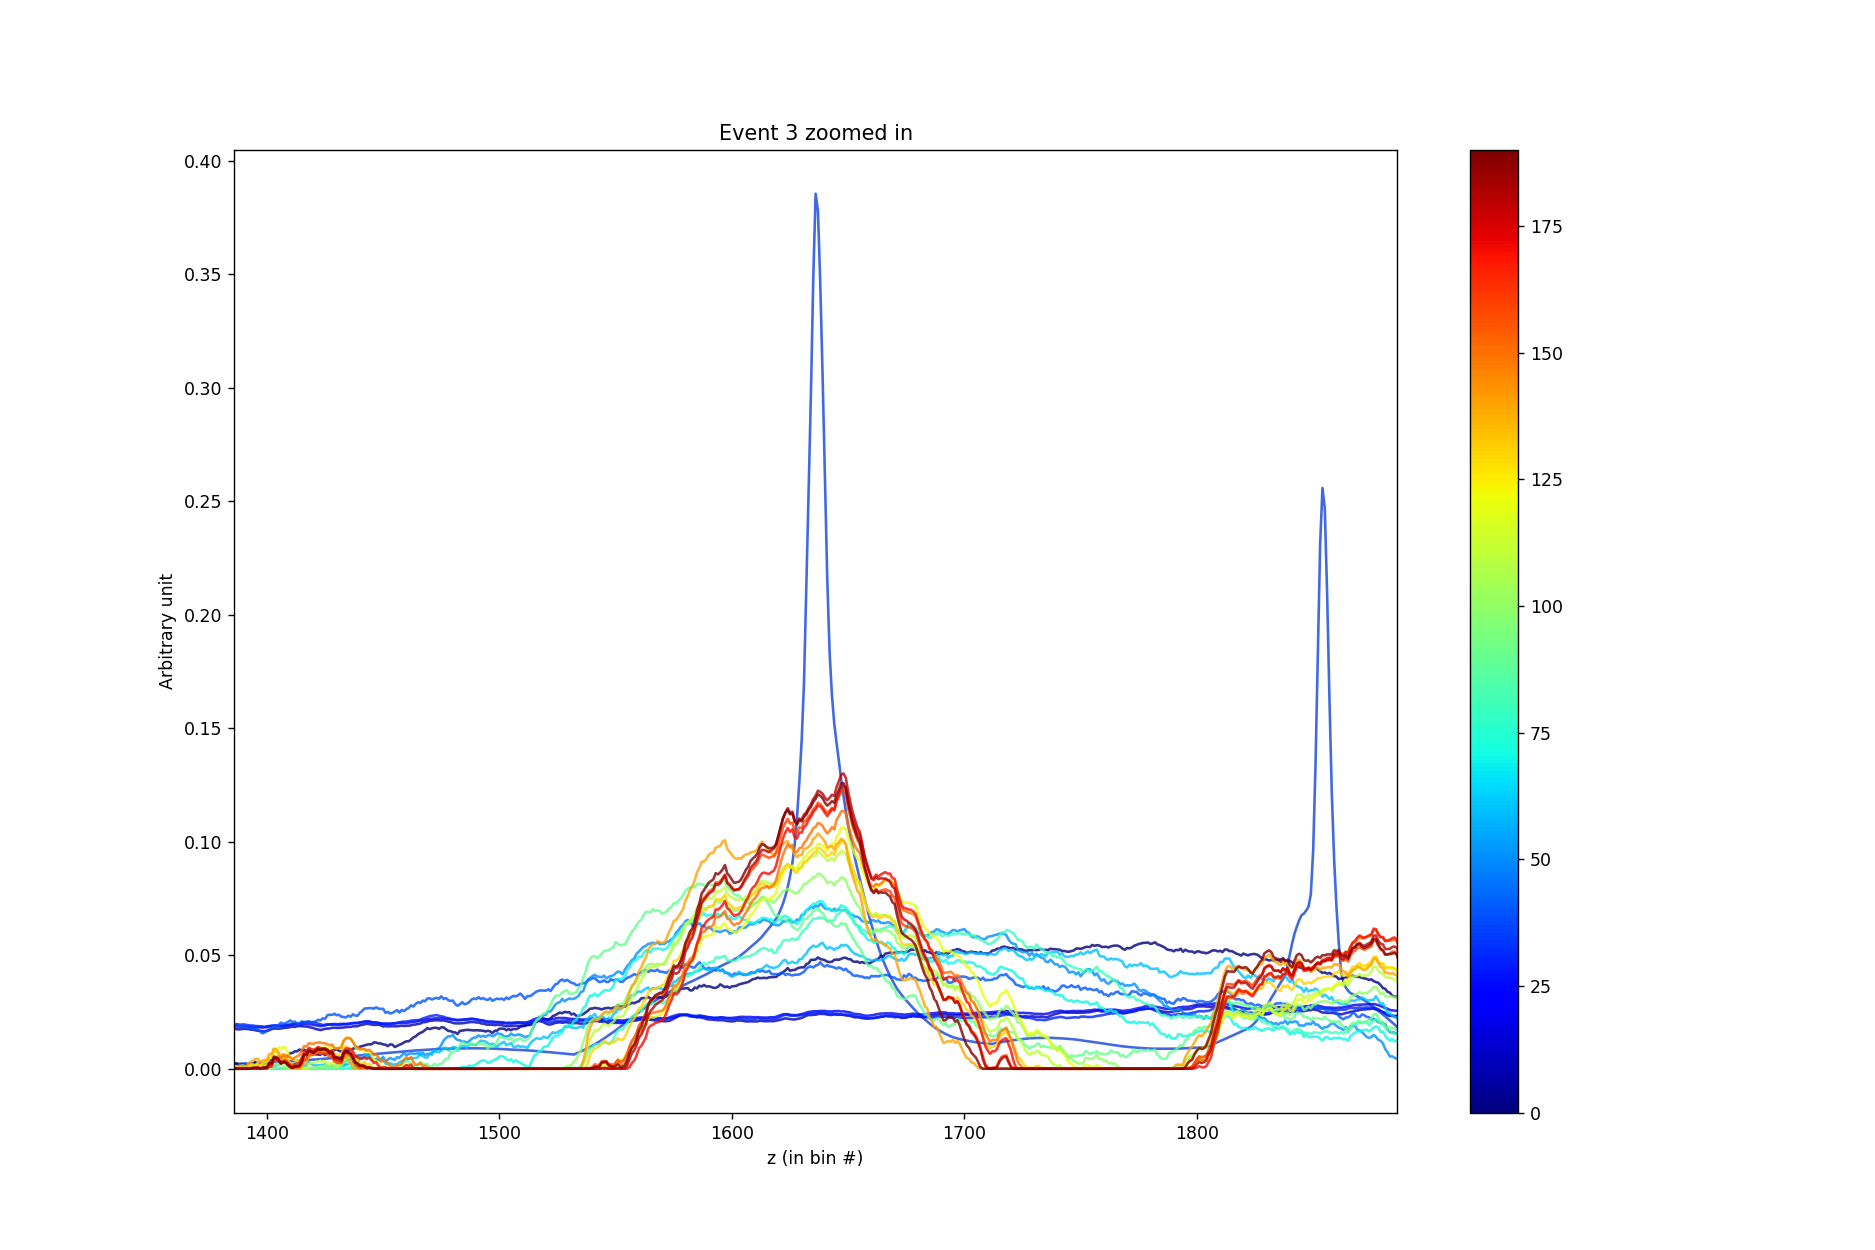

<IPython.core.display.Javascript object>


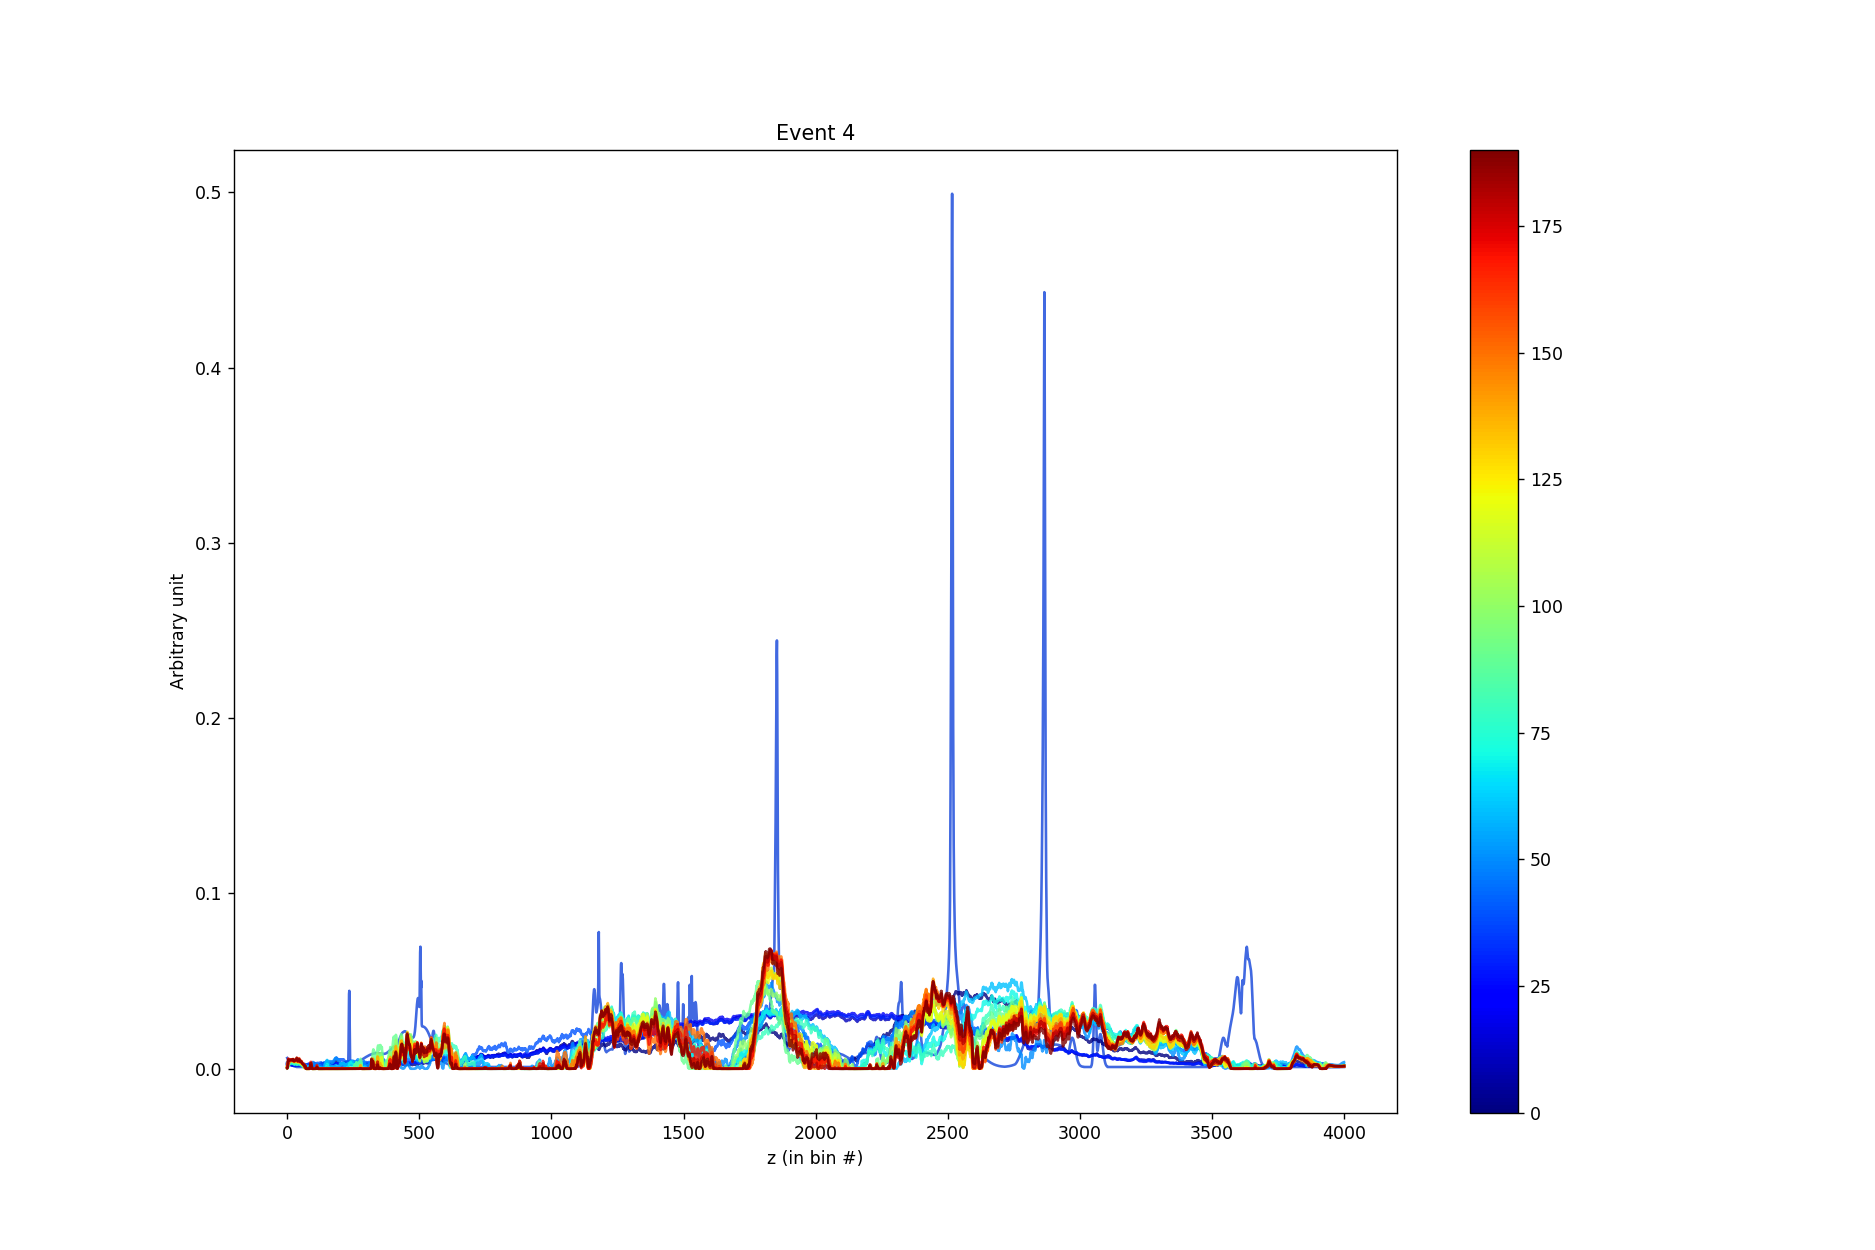

<IPython.core.display.Javascript object>


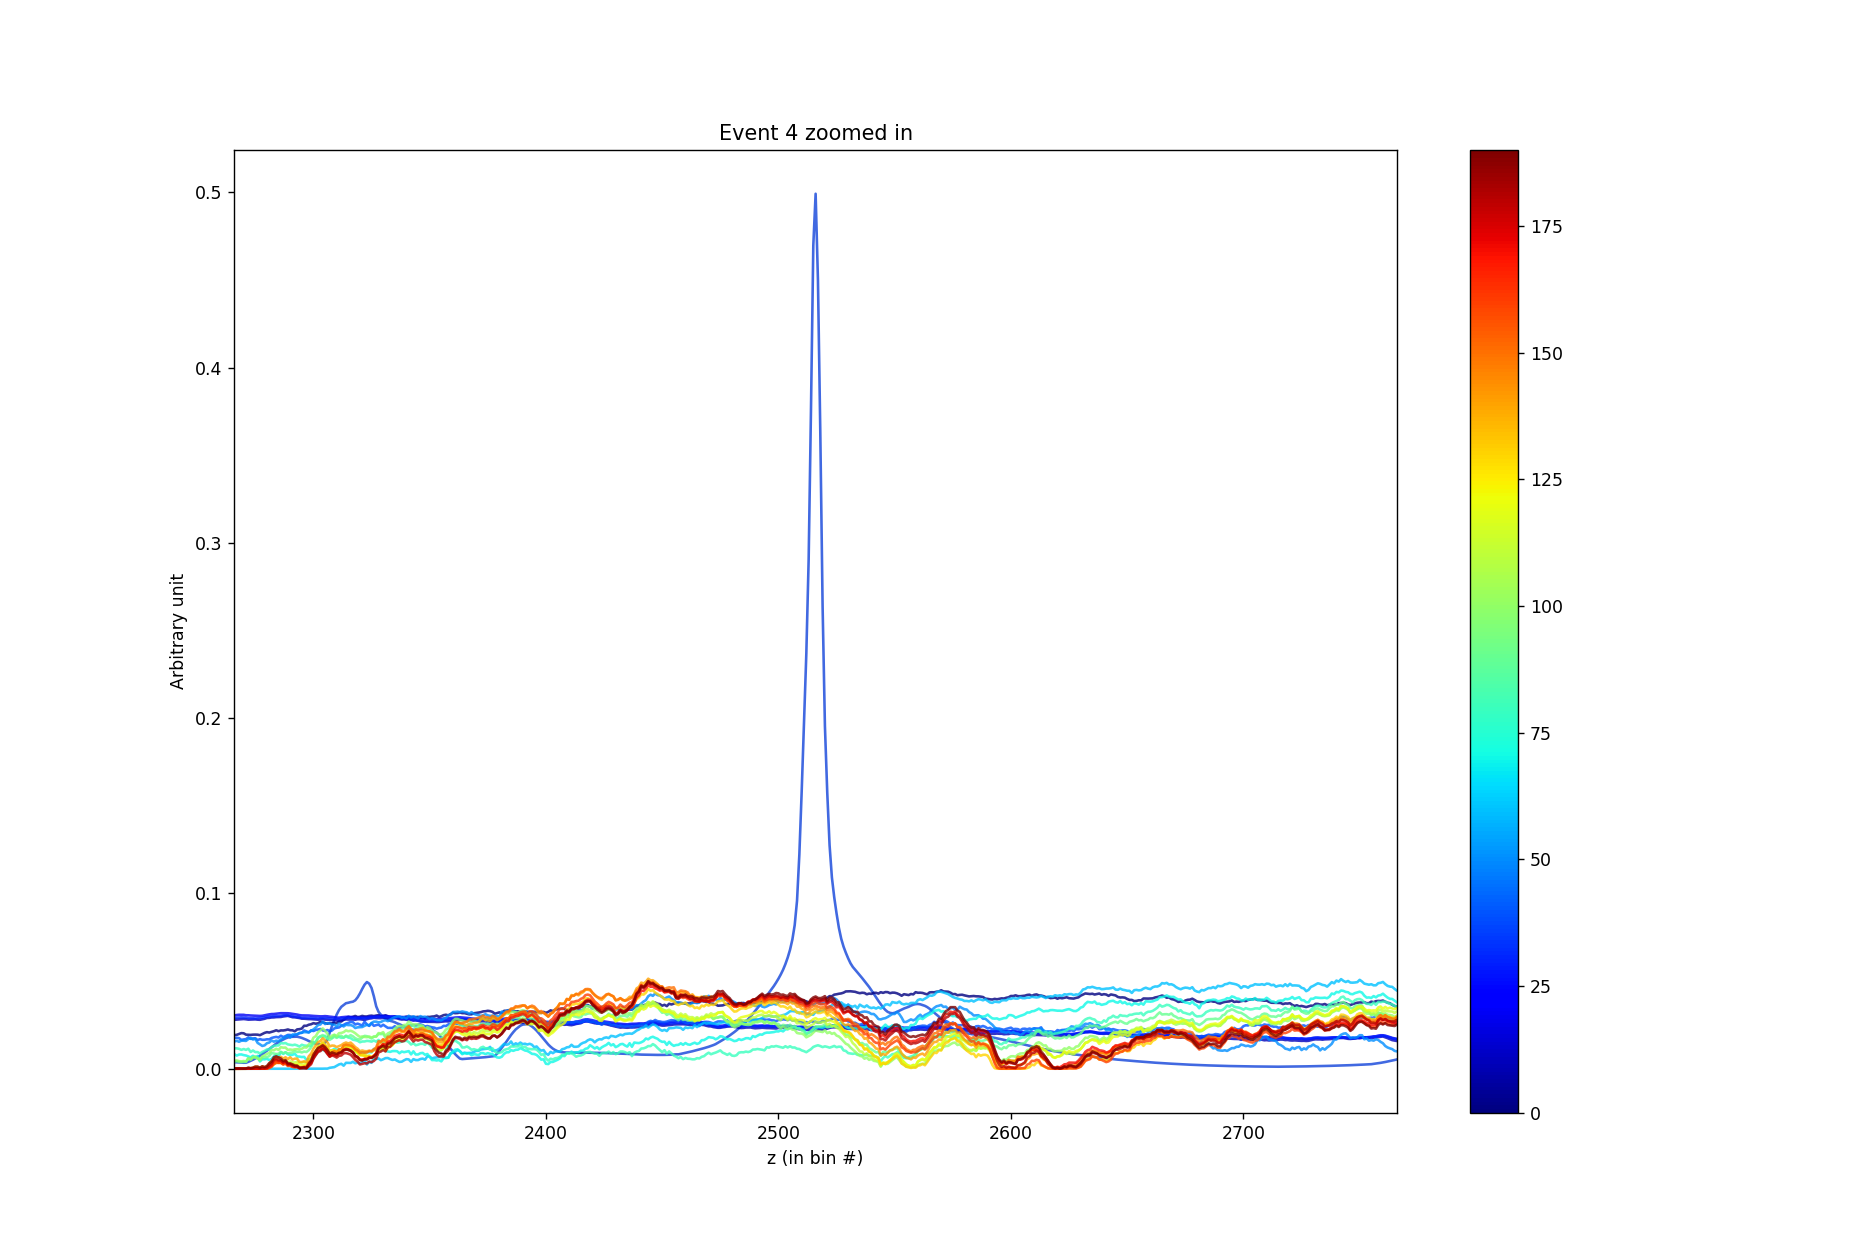

In [24]:
from functions.plotting_DDplus_hists import plot_DDplus_hists as Plot
Plot(state_dicts, data)